Metrics binary lens systems like planets
new format


# Extract fit and true values

In [178]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os, sys
import re
from tqdm.auto import tqdm
from pyLIMA import telescopes
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA import event
from tqdm.auto import tqdm
from astropy.time import Time
from astropy import constants as const
from astropy import units as u
from tqdm.auto import tqdm
import h5py
from astropy.table import QTable

import math
home = '/home/anibal/'
sys.path.append(home + '/roman_rubin/fit_codes')
# this codes are in the /fit_codes directory 
# https://github.com/anibal-art/roman_rubin/tree/main/fit_codes
# from fit_results import chi_dof, best_model, event_fits, sigmas
# # from fit_results import 
# from filter_curves import read_curves
# from analysis_metrics import m1,m2,m3, fit_true, metrics, sigma_ratio, bias_ratio, fit_values
from plot_models import plot_LCmodel
from plot_lightcurves import model
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# from plot_models import plot_only_model

import pandas as pd
import numpy as np
import math
import astropy.units as u
import astropy.constants as const
from tqdm.auto import tqdm



def event_fits(path_fits):
    '''
    return events in common with roman and rubin
    we have events that fits only one of two for unkown reasons
    '''
    
    files_fits = os.listdir(path_fits)
    
    files_roman = [f for f in files_fits if 'Roman' in f]
    files_rr = [f for f in files_fits if not 'Roman' in f]
    
    n_rom = [] # list with the event number
    for j in files_roman:
        number = int(re.findall(r'\d+', j)[0])
        n_rom.append(number)
    
    n_rr = [] # # list with the event number
    for j in files_rr:
        number = int(re.findall(r'\d+', j)[0])
        n_rr.append(number)
    
    # Convert lists to sets
    set1 = set(n_rom)
    set2 = set(n_rr)
    # Find the common elements using intersection
    common_elements = set1.intersection(set2)
    # Convert the result back to a list (if needed)
    common_elements_list = list(common_elements)
    return common_elements_list


In [179]:
path_ephemerides = '/home/anibal/files_db/james_webb.txt' #PATH TO EPHEMERIDES
path = '/home/anibal/results_roman_rubin/PB_new_format2/PB/'
save_results = path+'results/'
path_model = ['set_sim'+str(i)+'/' for i in range(1,9)]
path_fit = ['set_fit'+str(i)+'/' for i in range(1,9)]
path_set_sim = [path+'set_sim'+str(i)+'/' for i in range(1,9)]
path_set_fit = [path+'set_fit'+str(i)+'/' for i in range(1,9)]

In [180]:
label = {'piEE':'\\pi_{EE}','piEN':'\\pi_{EN}','rho':'\\rho','t0':'t_0','te':'t_E','u0':'u_0','s':'s','q':'q','alpha':'\\alpha', 'piE':'\\pi_E'}
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}'}


In [181]:
filenames =[path+"set_fit2/"+f for f in os.listdir(path+"set_fit2") if "RR" in f]
nflux = []
pflux = []
for i in range(len(filenames)):
    try:
        fit_data = np.load(filenames[i],allow_pickle=True).item()
        fit_flux = fit_data["best_model"][9:len(fit_data["best_model"])]
        if any(np.array(fit_flux)<0):
            nflux.append(1)
        else:
            pflux.append(1)
    except: 
        pass
print(len(nflux))
print(len(pflux))


0
637


In [182]:

def new_rows(camino,st):
    data_rr = np.load(camino,allow_pickle=True).item()
    labels_params = ['t0','u0','te','rho','s',
                           'q','alpha','piEN','piEE']
    fit_values = dict(zip(labels_params, 
                          data_rr['best_model'][0:9]))

    if any(np.diag(data_rr['covariance_matrix'])<0):
        fit_error = np.zeros(9)
    else:
        fit_error= np.sqrt(np.diag(data_rr['covariance_matrix']))[0:9]

    for j,key in enumerate(labels_params):
        fit_values[key+'_err']=fit_error[j]
    fit_values['Source'] = data_rr['true_params'].name+st*5000

    true_values = data_rr['true_params'][['t0','u0','te','rho','s','q','alpha','piEN','piEE']].to_dict()#.values[0:9])
    true_values['Source']=data_rr['true_params'].name+st*5000

    new_row_true = pd.DataFrame([true_values])
    new_row_fit = pd.DataFrame([fit_values])
    return new_row_true, new_row_fit

def fit_true(path):
    cols_true = ['Source','t0','u0','te','rho',
       's','q','alpha','piEN','piEE']
    cols_fit=cols_true+[t+'_err' for t in ['t0','u0','te','rho',
           's','q','alpha','piEN','piEE']]

    true=pd.DataFrame(columns=cols_true)
    fit_rr=pd.DataFrame(columns=cols_fit)
    fit_roman=pd.DataFrame(columns=cols_fit)
    fit_completed=[]
    for st in tqdm(range(1,5)):
        PATH = path+f'set_fit{st}/'
        # print(PATH)
        nevent = event_fits(PATH)
        # print(len(nevent))
        # print(len([f for f in os.listdir(path) if "RR" in f] ))
        # print(len([f for f in os.listdir(path) if "Roman" in f] ))
        list_files_rr= [f'Event_RR_{int(f)}_TRF.npy' for f in nevent]
        list_files_roman= [f'Event_Roman_{int(f)}_TRF.npy' for f in nevent]

        for i in range(len(nevent)):
            path_rr = PATH+list_files_rr[i]
            path_roman = PATH+list_files_roman[i]
            try:
            # if i==4:
                # print(path_rr)
                new_row_true, new_row_rr = new_rows(path_rr,st)
                new_row_true2, new_row_roman = new_rows(path_roman,st)
                # print(new_row_true)
                # print(any(new_row_true.values[0]==new_row_true2.values[0]))
                true = pd.concat([true, new_row_true], ignore_index=True)
                fit_rr = pd.concat([fit_rr, new_row_rr], ignore_index=True)
                fit_roman = pd.concat([fit_roman, new_row_roman], ignore_index=True)

                fit_completed.append(1)

            except:
            #     # print(i)
                fit_completed.append(0)
    return true, fit_rr, fit_roman

true, fit_rr, fit_roman = fit_true(path)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_6314/4186548327.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  true = pd.concat([true, new_row_true], ignore_index=True)
/tmp/ipykernel_6314/4186548327.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_rr = pd.concat([fit_rr, new_row_rr], ignore_index=True)
/tmp/ipykernel_6314/4186548327.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when

In [183]:
# try:
#     fit_rr = pd.read_csv(save_results+'fit_rr_ffp.csv')
#     fit_roman = pd.read_csv(save_results+'fit_roman_ffp.csv')
#     true = pd.read_csv(save_results+'true_ffp.csv')
# except:
#     fit_rr, fit_roman, true = fit_true(path)
#     fit_rr.to_csv(save_results+'fit_rr_ffp.csv', index=False)
#     fit_roman.to_csv(save_results+'fit_roman_ffp.csv', index=False)
#     true.to_csv(save_results+'true_ffp.csv', index=False)

In [184]:

def read_data(path_model):
    # Open the HDF5 file and load data using specified names
    with h5py.File(path_model, 'r') as file:
        # Load array with string with info of dataset using its name
        info_dataset = file['Data'][:]
        info_dataset = [file['Data'][:][0].decode('UTF-8'), file['Data'][:][1].decode('UTF-8'),
                        [file['Data'][:][2].decode('UTF-8'), [0, 0]]]
        # Dictionary using its name
        pyLIMA_parameters = {key: file['pyLIMA_parameters'].attrs[key] for key in file['pyLIMA_parameters'].attrs}
        # Load table using its name
        bands = {}
        for band in ("W149", "u", "g", "r", "i", "z", "y"):
            loaded_table = QTable()
            for col in file[band]:
                loaded_table[col] = file[band][col][:]
            bands[band] = loaded_table
        return info_dataset, pyLIMA_parameters, bands


def chichi(name_file):
    '''
    name_file(str):This function receives as input the name of the file
    example: /home/user/model/set_sim1/Event_RR_42_trf.npy.
    '''
    # print(name_file[name_file.index('Event_')-2])
    nset = int(name_file[name_file.index('Event_')-2:name_file.index('Event_')-1])

    # print(nset)
    name_set = 'set_sim'+str(nset)
    directory_simset = name_file[0:name_file.index('set')]+name_set+'/'
    # print()
    nevent = re.sub(r'\D', '', name_file[name_file.index('Event_'):-1])
    
    model_file = directory_simset+'Event_'+str(nevent)+'.h5'
    info_dataset, model_params, curves=read_data(name_file)
    # curves,model_params = read_curves(model_file)
    name_file_rr=name_file[0:name_file.index('set')]+f"/set_fit{nset}/Event_RR_{nevent}_TRF.npy"
    name_file_roman=name_file[0:name_file.index('set')]+f"/set_fit{nset}/Event_Roman_{nevent}_TRF.npy"
    data_rr = np.load(name_file_rr,allow_pickle=True)
    data_roman = np.load(name_file_roman,allow_pickle=True)
    # print(data_rr)
    try:
        chi_rr =data_rr.item()["chi2"] 
        chi_roman =data_roman.item()["chi2"]

        dof_rr = sum([len(curves[key]) for key in curves])-len([len(curves[key]) for key in curves if not len(curves[key])==0])*2-9
        dof_roman =len(curves['W149'])-2-9
        # print(model_params)
        # print(chi_roman/dof)
        return chi_rr/dof_rr, chi_roman/dof_roman
    except:
        return 0,0

name_file = path+'set_sim1/Event_298.h5'
info_dataset, pyLIMA_parameters, bands=read_data(name_file)
# print(bands.keys())
chichi(name_file)

(1.0003576578954543, 1.0005167189450392)

In [185]:
from tqdm.auto import tqdm

# try:
    # fit_rr["chi2"]
# except:
    # name_file = [f for f in os.listdir(path+"set_sim1/")]
    # print(path+"set_fit1/"+name_file[0])
    # print(chichi(path+"set_sim1/"+name_file[2]))

id_to_chi2_rr = {}
id_to_chi2_roman = {}

for i in tqdm(range(1,9)):
    common_elements_list = event_fits(path+f"set_fit{i}/")
    if not len(common_elements_list)==0:
        for j in range(len(common_elements_list)):
            name_file = f"Event_{common_elements_list[j]}.h5"
            chi2rr, chi2roman = chichi(path+f"set_sim{i}/"+name_file)
            # print(chi2rr, chi2roman)
            id_to_chi2_rr[int(common_elements_list[j]+i*5000)] =chi2rr
            id_to_chi2_roman[int(common_elements_list[j]+i*5000)] =chi2roman

fit_rr['chi2'] = fit_rr['Source'].map(id_to_chi2_rr)
fit_roman['chi2'] = fit_roman['Source'].map(id_to_chi2_roman)
# fit_rr.to_csv(save_results+'fit_rr_ffp.csv', index=False)
# fit_roman.to_csv(save_results+'fit_roman_ffp.csv', index=False)
# true.to_csv(save_results+'true_ffp.csv', index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

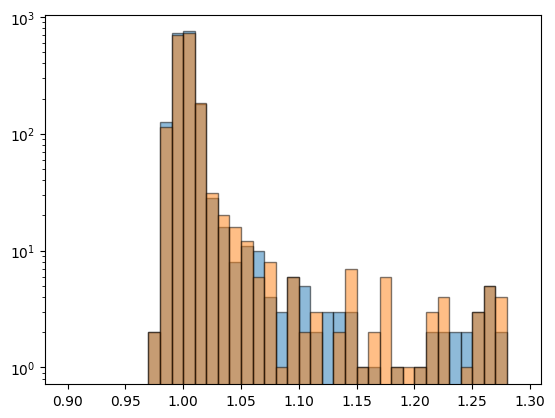

In [186]:
plt.hist(fit_rr['chi2'].values, bins=np.arange(0.9,1.3,0.01),alpha=0.5,edgecolor='k')
plt.hist(fit_roman['chi2'].values, bins=np.arange(0.9,1.3,0.01),alpha=0.5,edgecolor='k')
plt.yscale('log')

In [187]:
# !pip install seaborn

In [188]:

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

cov_piEE_piEN={}
cov_rho_piEE={}
cov_rho_piEN={}
cov_piEE_piEN_rom={}
cov_rho_piEE_rom={}
cov_rho_piEN_rom={}

for i in tqdm(range(len(fit_rr))):
    nsource = fit_rr["Source"].iloc[i]
    nset = int(nsource/5000)
    nevent = nsource-nset*5000
    
    data = np.load(path+f"set_fit{nset}/Event_RR_{nevent}_TRF.npy",allow_pickle=True)
    data_rom = np.load(path+f"set_fit{nset}/Event_Roman_{nevent}_TRF.npy",allow_pickle=True)
    
    best_model = data.item()['best_model']
    covariance_matrix = data.item()['covariance_matrix']
    cov_piEE_piEN[nsource]=covariance_matrix[8,7]
    cov_rho_piEE[nsource]=covariance_matrix[3,7]
    cov_rho_piEN[nsource]=covariance_matrix[3,8]
    
    best_model_rom = data_rom.item()['best_model']
    covariance_matrix_rom = data_rom.item()['covariance_matrix']
    cov_piEE_piEN_rom[nsource]=covariance_matrix_rom[8,7]
    cov_rho_piEE_rom[nsource]=covariance_matrix_rom[3,7]
    cov_rho_piEN_rom[nsource]=covariance_matrix_rom[3,8]
    
fit_rr["cov_piEE_piEN"]= fit_rr['Source'].map(cov_piEE_piEN)
fit_rr["cov_rho_piEE"] = fit_rr['Source'].map(cov_rho_piEE)
fit_rr["cov_rho_piEN"] = fit_rr['Source'].map(cov_rho_piEN)
fit_roman["cov_piEE_piEN"]= fit_rr['Source'].map(cov_piEE_piEN_rom)
fit_roman["cov_rho_piEE"] = fit_rr['Source'].map(cov_rho_piEE_rom)
fit_roman["cov_rho_piEN"] = fit_rr['Source'].map(cov_rho_piEN_rom)

  0%|          | 0/2008 [00:00<?, ?it/s]

In [189]:
for i in range(1,2):
    lista_sim1 = [int(''.join(re.findall(r'\d+', f))) for f in os.listdir(path+f'set_sim{i}') if 'txt' in f]
print(len(lista_sim1))

for i in range(1,2):
    lista_fit1 = [int(''.join(re.findall(r'\d+', f))) for f in os.listdir(path+f'set_fit{i}') if 'npy' in f]
print(len(lista_fit1))


set1 = set(lista_sim1)
set2 = set(lista_fit1)

# Find numbers that are unique to each list
unique_to_list1 = set1 - set2
unique_to_list2 = set2 - set1


0
3098


0 0 t0
0 1 u0
0 2 te
1 0 rho
1 1 s
1 2 q
2 0 alpha
2 1 piEN
2 2 piEE


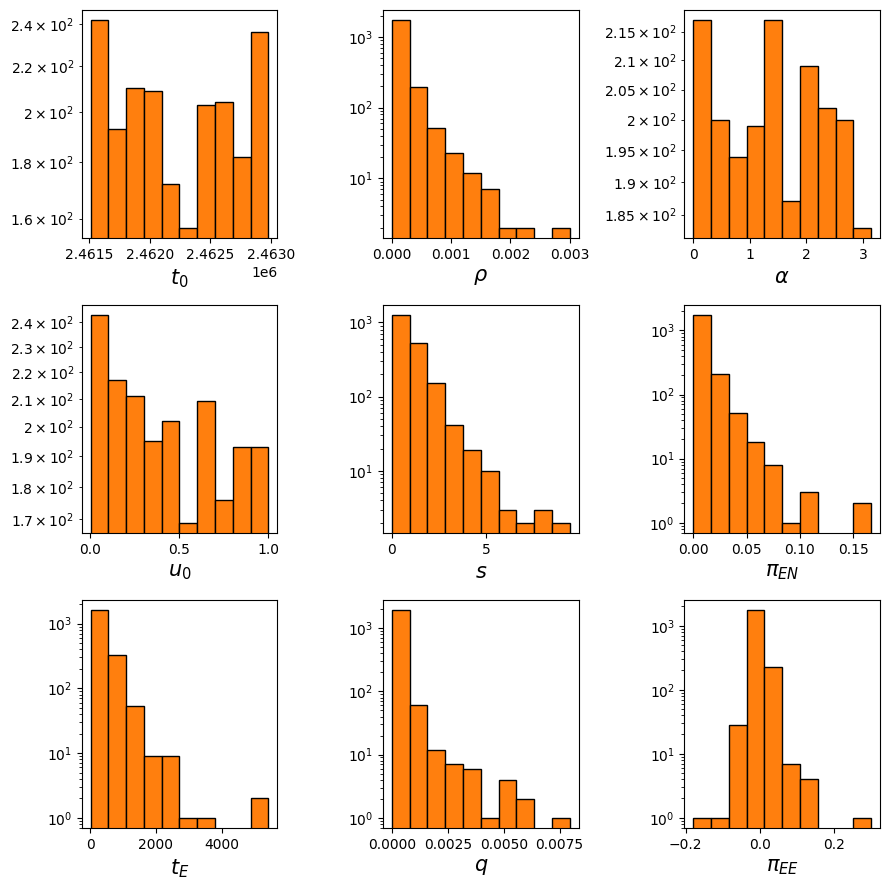

In [190]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i,p in enumerate(['t0', 'u0', 'te', 'rho', 's', 'q', 'alpha', 'piEN', 'piEE']):
    row, col = divmod(i, 3)
    
    print(row,col,p)
    axs[col,row].hist(true[p])
    axs[col,row].hist(true[p],edgecolor='black')
    axs[col,row].set_xlabel(f'${label[p]}$',fontsize=15)
    axs[col,row].set_yscale('log')
    # axs[col,row].set_xscale('log')
    if p == 'piE':
        axs[col,row].hist(np.sqrt(true['piEE']**2 + true['piEN']**2),edgecolor='black')
        axs[col,row].set_xlabel(f'${label[p]}$',fontsize=15)
        axs[col,row].set_yscale('log')

plt.tight_layout()
plt.show()

In [191]:
1/3

0.3333333333333333

In [192]:
int(7216-5000)

2216

In [193]:
print(true[["Source"]][(true["s"]<1/3)&(true["u0"]<0.1)])
met_3_rr[met_3_rr["Source"]==5164]#.isin(true[["Source"]][(true["s"]<1/3)&(true["u0"]<0.1)])]

     Source
13     5164
120    6222
161    6653
181    6788
189    6874
230    7216
233    7258
244    7402
255    7487
296    7966
374    8727
384    8809
393    8904
508   10080
538   10319
540   10331
643   11375
672   11672
821   13098
829   13162
856   13363
1013  14979
1038  15266
1060  15479
1109  16045
1111  16081
1121  16190
1167  16614
1194  16884
1306  18125
1324  18276
1326  18284
1543  20448
1685  21820
1688  21876
1735  22326
1789  22837
1870  23694
1901  23965
1939  24370
2005  24979


NameError: name 'met_3_rr' is not defined

In [ ]:
# fit_rr["chi2"][fit_rr["s"]<1/3]

In [ ]:
# Create a figure and a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Roman+Rubin data - subplot (0, 0)

piE_rr = np.sqrt(fit_rr['piEN']**2 + fit_rr['piEE']**2)
sigma_piE_rr = (1/piE_rr) * np.sqrt((fit_rr['piEN']*fit_rr['piEN_err'])**2 + (fit_rr['piEE']*fit_rr['piEE_err'])**2)
f_rr = [f for f in sigma_piE_rr/piE_rr if f<0.1]
fraction_roman = len(f_rr)/len(sigma_piE_rr/piE_rr)
axs[0, 0].set_title('Roman+Rubin data: fraction $\pi_{E}/\sigma_{\pi_{E}}$<1 = '+str(round(fraction_roman,3)))
h = axs[0, 0].hist2d(piE_rr, sigma_piE_rr/piE_rr, bins=(np.arange(0, 0.1, 0.01), np.arange(0, 5, 0.5)))
axs[0, 0].set_xlabel(r'$\pi_{E}$', fontsize=20)
axs[0, 0].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[0,0])  # Add color bar to the subplot


# Plot for Roman+Rubin data - subplot (0, 1)
axs[0, 1].set_title('Roman+Rubin data')
# piE_rr = np.sqrt(fit_rr['piEN']**2 + fit_rr['piEE']**2)
sigma_piE_rr = (1/piE_rr) * np.sqrt((fit_rr['piEN']*fit_rr['piEN_err'])**2 + (fit_rr['piEE']*fit_rr['piEE_err'])**2)
h=axs[0, 1].hist2d(fit_rr['te'], sigma_piE_rr/piE_rr, bins=(np.arange(0, 1000, 100), np.arange(0, 20, 1)))
axs[0, 1].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
axs[0, 1].set_xlabel(r'$t_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[0,1])  # Add color bar to the subplot
# Plot for Roman data only - subplot (1, 0)

piE_roman = np.sqrt(fit_roman['piEN']**2 + fit_roman['piEE']**2)
sigma_piE_roman = (1/piE_roman) * np.sqrt((fit_roman['piEN']*fit_roman['piEN_err'])**2 + (fit_roman['piEE']*fit_roman['piEE_err'])**2)
sigma_piE_roman = (1/piE_roman) * np.sqrt((fit_roman['piEN']*fit_roman['piEN_err'])**2 + (fit_roman['piEE']*fit_roman['piEE_err'])**2)
f_roman = [f for f in sigma_piE_roman/piE_roman if f<0.1]
fraction_roman = len(f_roman)/len(sigma_piE_roman/piE_roman)
axs[1, 0].set_title('Roman data only: fraction $\pi_{E}/\sigma_{\pi_{E}}$<1 = '+str(round(fraction_roman,3)))
h=axs[1, 0].hist2d(piE_roman, sigma_piE_roman/piE_roman, bins=(np.arange(0, 0.1, 0.01), np.arange(0, 5, 0.5)))
axs[1, 0].set_xlabel(r'$\pi_{E}$', fontsize=20)
axs[1, 0].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[1,0])  # Add color bar to the subplot
# Plot for Roman data only - subplot (1, 1)

# piE_roman = np.sqrt(fit_roman['piEN']**2 + fit_roman['piEE']**2)
axs[1, 1].set_title('Roman data only')
h=axs[1, 1].hist2d(fit_roman['te'], sigma_piE_roman/piE_roman, bins=(np.arange(0, 1000, 100), np.arange(0, 20, 1)))
axs[1, 1].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
axs[1, 1].set_xlabel(r'$t_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[1,1])  # Add color bar to the subplot
# axs[1, 1].set_colorbar()
# Adjust layout to prevent clipping of titles
plt.tight_layout()
# Show the plot
plt.show()


# Veamos las metricas

In [ ]:
# save_results = '/home/anibal/results_roman_rubin/FFP_v5/FFP/results/'
met_1_rr = pd.DataFrame(columns = true.columns)
met_1_roman= pd.DataFrame(columns = true.columns)
met_2_rr = pd.DataFrame(columns = true.columns)
met_2_roman= pd.DataFrame(columns = true.columns)
met_3_rr = pd.DataFrame(columns = true.columns)
met_3_roman= pd.DataFrame(columns = true.columns)
err_ratio= pd.DataFrame(columns = true.columns)
residuals_ratio= pd.DataFrame(columns = true.columns)
err_ratio['Source']=true['Source']
residuals_ratio['Source']=true['Source']

met_1_roman['Source']=true['Source']
met_1_rr['Source']=true['Source']
met_2_roman['Source']=true['Source']
met_2_rr['Source']=true['Source']
met_3_roman['Source']=true['Source']
met_3_rr['Source']=true['Source']
keys = ['t0',
'u0',
'te',
'rho',
's',
'q',
'alpha',
'piEN',
'piEE']
for key in keys:
    met_1_rr[key] = abs(true[key]-fit_rr[key])/true[key]
    met_1_roman[key] = abs(true[key]-fit_roman[key])/true[key]
    met_2_rr[key] = abs(true[key]-fit_rr[key])/fit_rr[key+'_err']
    met_2_roman[key] = abs(true[key]-fit_roman[key])/fit_roman[key+'_err']
    met_3_rr[key] = abs(fit_rr[key+'_err'])/fit_rr[key]
    met_3_roman[key] = abs(fit_roman[key+'_err'])/fit_roman[key]
    err_ratio[key]=abs(fit_rr[key+'_err'])/fit_roman[key+'_err']
    residuals_ratio[key]=abs(fit_rr[key+'_err'])/fit_roman[key+'_err']

In [ ]:
met_1_rr.to_csv(path+'results/'+'met_1_rr.csv', index=False)
met_1_roman.to_csv(path+'results/'+'met_1_roman.csv', index=False)
met_2_rr.to_csv(path+'results/'+'met_2_rr.csv', index=False)
met_2_roman.to_csv(path+'results/'+'met_2_roman.csv', index=False)
met_3_rr.to_csv(path+'results/'+'met_3_rr.csv', index=False)
met_3_roman.to_csv(path+'results/'+'met_3_roman.csv', index=False)
err_ratio.to_csv(path+'results/'+'err_ratio.csv', index=False)
residuals_ratio.to_csv(path+'results/'+'residuals_ratio.csv', index=False)

In [ ]:
met_1_rr = pd.read_csv(path+'results/'+'met_1_rr.csv')
met_1_roman=pd.read_csv(path+'results/'+'met_1_roman.csv')
met_2_rr=pd.read_csv(path+'results/'+'met_2_rr.csv')
met_2_roman=pd.read_csv(path+'results/'+'met_2_roman.csv')
met_3_rr=pd.read_csv(path+'results/'+'met_3_rr.csv')
met_3_roman=pd.read_csv(path+'results/'+'met_3_roman.csv')
err_ratio=pd.read_csv(path+'results/'+'err_ratio.csv')
residuals_ratio=pd.read_csv(path+'results/'+'residuals_ratio.csv')

## Distribuciones de las metricas


In [ ]:
def group_consecutive_numbers(numbers):
    '''
    Defino comienzo y finalizacion de temporadas de observacion de Rubin en el campo de Roman
    '''
    numbers.sort()
    groups = []
    current_group = [numbers[0]]

    for i in range(1, len(numbers)):
        if numbers[i] - current_group[-1] < 60:
            current_group.append(numbers[i])
        else:
            groups.append(current_group)
            current_group = [numbers[i]]

    if current_group:
        groups.append(current_group)

    return groups



In [ ]:
from astropy import units
%matplotlib inline

path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'
dataSlice = np.load(path_dataslice, allow_pickle=True)
nominal_seasons = [
    {'start': '2027-02-11T00:00:00', 'end': '2027-04-24T00:00:00'},
    {'start': '2027-08-16T00:00:00', 'end': '2027-10-27T00:00:00'},
    {'start': '2028-02-11T00:00:00', 'end': '2028-04-24T00:00:00'},
    {'start': '2030-02-11T00:00:00', 'end': '2030-04-24T00:00:00'},
    {'start': '2030-08-16T00:00:00', 'end': '2030-10-27T00:00:00'},
    {'start': '2031-02-11T00:00:00', 'end': '2031-04-24T00:00:00'},
]

dataSlice['observationStartMJD']
consecutive_numbers = dataSlice['observationStartMJD']
result = group_consecutive_numbers(consecutive_numbers)
rubin_seasons = []
roman_seasons = []
for group in result:
    rubin_seasons.append((min(group)+2400000.5,max(group)+2400000.5))
for season in nominal_seasons:
    roman_seasons.append((Time(season['start'], format='isot').jd,Time(season['end'], format='isot').jd))


In [ ]:
def intervals_overlap(interval1, interval2):
    start1, end1 = interval1
    start2, end2 = interval2
    return (start1 <= end2 and end1 >= start2) or (start2 <= end1 and end2 >= start1)

categories = []
for i in range(len(true)):
    interval1 = (true['t0'].values[i]-true['te'].values[i], true['t0'].values[i]+true['te'].values[i])

    overlap_rubin=False
    for j in range(len(rubin_seasons)):
        interval2 = rubin_seasons[j]
        if intervals_overlap(interval1, rubin_seasons[j]):
            overlap_rubin=True
            break

    overlap_roman = False
    for k in range(len(roman_seasons)):
        interval2 = roman_seasons[k]
        if intervals_overlap(interval1, roman_seasons[k]):
            overlap_roman = True
            break
    
    if (overlap_rubin==True) and (overlap_roman==True):
        categories.append('A')
    if (overlap_rubin==True) and (not overlap_roman==True):
        categories.append('B')
    if (not overlap_rubin==True) and (not overlap_roman==True):
        categories.append('C')
    if (not overlap_rubin==True) and (overlap_roman==True):
        categories.append('D')

true['categories'] = categories

In [ ]:
print(set(true['categories']))
print(len(true[true['categories']=='A']))
print(len(true[true['categories']=='B']))
print(len(true[true['categories']=='C']))
print(len(true[true['categories']=='D']))

In [ ]:
#set(true['categories'])
plt.figure(figsize=(8,1))
for group in result:
    plt.axvspan(min(group)+2400000.5,max(group)+2400000.5,alpha=0.4)

for fil in 'ugrizy':
    plt.plot(dataSlice['observationStartMJD'][dataSlice['filter']==fil]+2400000.5, np.ones(len(dataSlice['observationStartMJD'][dataSlice['filter']==fil])),'|',markersize=30)

for season in nominal_seasons:
    plt.axvspan(Time(season['start'], format='isot').jd,Time(season['end'], format='isot').jd,alpha=0.5,color='red')

plt.xlabel('MJD')

cats="ABCD"
color_cat={'A':'b','B':'r','C':'k','D':'purple'}
for cat in cats:
    for i in range(0,1):
        # if true['te'].values[i]<60:
        # interval = (true['t0'][true["categories"]==cat].values[i]-true['te'][true["categories"]==cat].values[i]-2400000.5, true['t0'][true["categories"]==cat].values[i]+true['te'][true["categories"]==cat].values[i]-2400000.5)
        plt.errorbar(true[true["categories"]==cat]['t0'].values[i],np.random.uniform(0,1),yerr=None,xerr=true[true["categories"]==cat]['te'].values[i],color=color_cat[cat],marker='.',alpha=1,capsize=2)


For the propagation of $\pi_E$ I have to take into account the term outside the diagonal in the covariance matrix
$$\sigma_{\pi_E}^2 = 2Cov(\pi_{EE},\pi_{EN})\frac{\partial \pi_E}{\partial \pi_{EE}}\frac{\partial \pi_E}{\partial \pi_{EN}}+\left(\frac{\partial \pi_E}{\partial \pi_{EE}}\sigma_{\pi_{EE}}\right)^2+\left(\frac{\partial \pi_E}{\partial \pi_{EN}}\sigma_{\pi_{EN}}\right)^2$$

In [ ]:
fit_rr['piE']=np.sqrt(fit_rr['piEN']**2+fit_rr['piEE']**2)
fit_rr['piE_err'] = (1/fit_rr['piE'])*np.sqrt((fit_rr['piEN_err']*fit_rr['piEN'])**2+(fit_rr['piEE_err']*fit_rr['piEE'])**2+2*fit_rr['piEE']*fit_rr['piEN']*fit_rr['cov_piEE_piEN'])

fit_roman['piE']=np.sqrt(fit_roman['piEN']**2+fit_roman['piEE']**2)
fit_roman['piE_err'] = (1/fit_roman['piE'])*np.sqrt((fit_roman['piEN_err']*fit_roman['piEN'])**2+(fit_roman['piEE_err']*fit_roman['piEE'])**2+2*fit_roman['piEE']*fit_roman['piEN']*fit_roman['cov_piEE_piEN'])

true['piE']=np.sqrt(true['piEN']**2+true['piEE']**2)



In [86]:
residuals_ratio['piE'] = np.abs(fit_rr['piE']-true['piE'])/np.abs(fit_roman['piE']-true['piE'])
err_ratio['piE'] = fit_rr['piE_err']/fit_roman['piE_err']

In [87]:
m1_piE_rr = np.abs(fit_rr['piE']-true['piE'])/true['piE']
m1_piE_roman = np.abs(fit_roman['piE']-true['piE'])/true['piE']
met_1_roman['piE'] = m1_piE_roman
met_1_rr['piE'] = m1_piE_rr

m2_piE_rr = np.abs(fit_rr['piE']-true['piE'])/fit_rr['piE_err']
m2_piE_roman = np.abs(fit_roman['piE']-true['piE'])/fit_roman['piE_err']
met_2_roman['piE'] = m2_piE_roman
met_2_rr['piE'] = m2_piE_rr

m3_piE_rr = fit_rr['piE_err']/fit_rr['piE']
m3_piE_roman = fit_roman['piE_err']/fit_roman['piE']
met_3_roman['piE'] =m3_piE_roman 
met_3_rr['piE'] = m3_piE_rr


0 0
0 1
0 2


/tmp/ipykernel_15874/3574844564.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


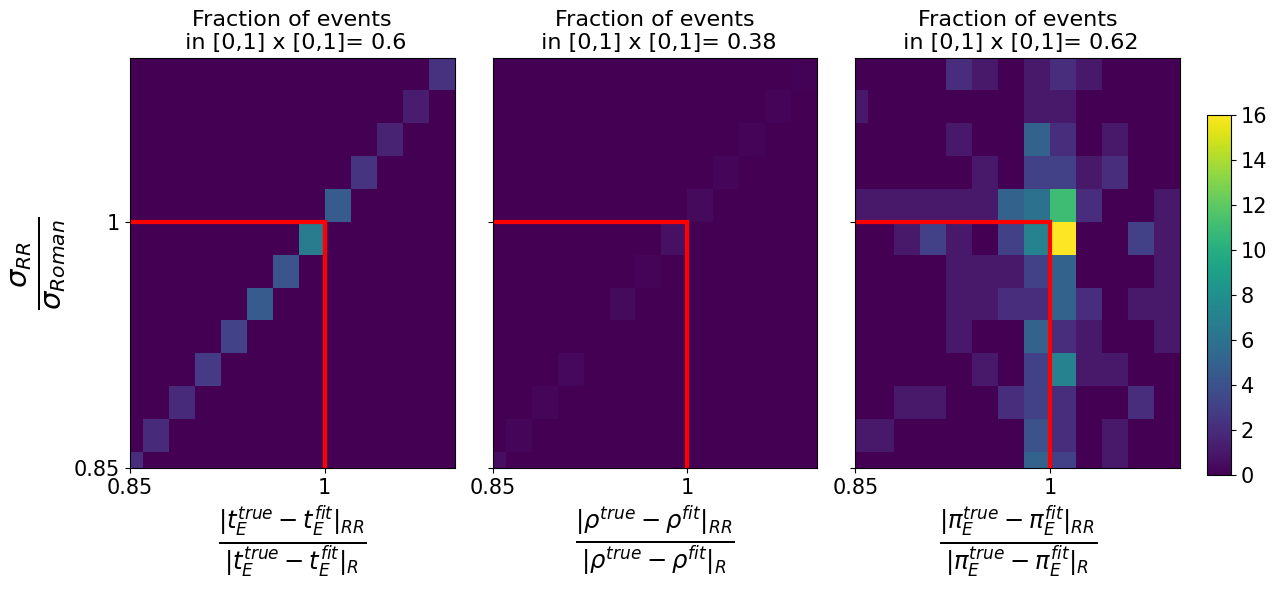

In [88]:
# def plot_comparisons(err_ratio, residuals_ratio,opsim,model):
%matplotlib inline
plt.close('all')
err_ratio, residuals_ratio,opsim,model = err_ratio, residuals_ratio, 'Baseline', 'USPL'
fractions = []
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}', 'piE':'\pi_{E}'}
# Define your data and properties as given in your code
if 'PSPL' in model:
    properties = ('t0', 'u0', 'te', 'piEE', 'piEN')
elif 'USPL' in model:
    properties = ('te','rho', 'piE')
else:
    properties = ('t0', 'u0', 'te','rho', 's', 'q', 'alpha', 'piEE', 'piEN')
fig, axs = plt.subplots(1,3, figsize=(12, 6),sharey=True)
cbar_axs = [fig.add_axes([1.01, 0.2, 0.02, 0.6])]#,  # Color bar for the first row
Categories = {'B':'Roman gap but Rubin season','C':'Rubin gap but Roman season','D':'Overlap seasons'}
n=1
for i, p in enumerate(properties):
    row, col = divmod(i, 3) 
    print(row, col)

    im = axs[col].hist2d(residuals_ratio[p]
                              , err_ratio[p], bins=[np.arange(0, 1.2, 0.02), np.arange(0., 1.2, 0.02)])
    # print(len(m1_ratio[p]))
    label_m1 = r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{RR}}{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{R}}$'#+f'{labels[p]}'+'^{true}}$'#+r'$\frac{|'+f'{p}'+'^{true}-'+f'{p}'+'^{fit}|_{RR}}{'+f'{p}'+'^{true}}$'
    axs[col].set_xlabel(label_m1,fontsize=25)
    axs[ col].set_xticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
    axs[ col].set_yticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
    # Calculate the number of events in [0,1] x [0,1] square
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    axs[ col].plot(np.linspace(0.,1,15),np.ones(15),color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.ones(15),np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.linspace(0.,1,15),np.ones(15)*0,color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.ones(15)*0,np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)

    df = err_ratio[(err_ratio[p]<y_max) & (err_ratio[p]>y_min)]
    # display(df)
#         # df0 = residuals_ratio[residuals_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
    number_in_square = len(df[(df[p] <x_max) & (df[p] >x_min)])/len(residuals_ratio)

#         # Label for the text annotation
    text_x = 1  # X-coordinate for the text
    text_y = 0.4  # Y-coordinate for the text (negative to go below the figure)
    text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
    axs[ col].set_title(text, fontsize = 16)

    if col == 0:
        axs[ col].set_ylabel(r'$\frac{ \sigma_{RR} }{\sigma_{Roman}}$',fontsize=30)

    axs[ col].set_xlim(0.85,1.1)
    axs[ col].set_ylim(0.85, 1.1)

    fig.colorbar(im[3], cax=cbar_axs[0])
    cbar = fig.colorbar(im[3], cax=cbar_axs[0])
    cbar.ax.tick_params(labelsize=15)
# plt.suptitle(opsim  +f' {model} - '+Categories[cat],fontsize=30)    
plt.tight_layout()
# plt.savefig(f'/home/anibal/FIGURES_roman_rubin/{model}_{opsim}_{cat}.png')
plt.show()

/tmp/ipykernel_15874/3298186052.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


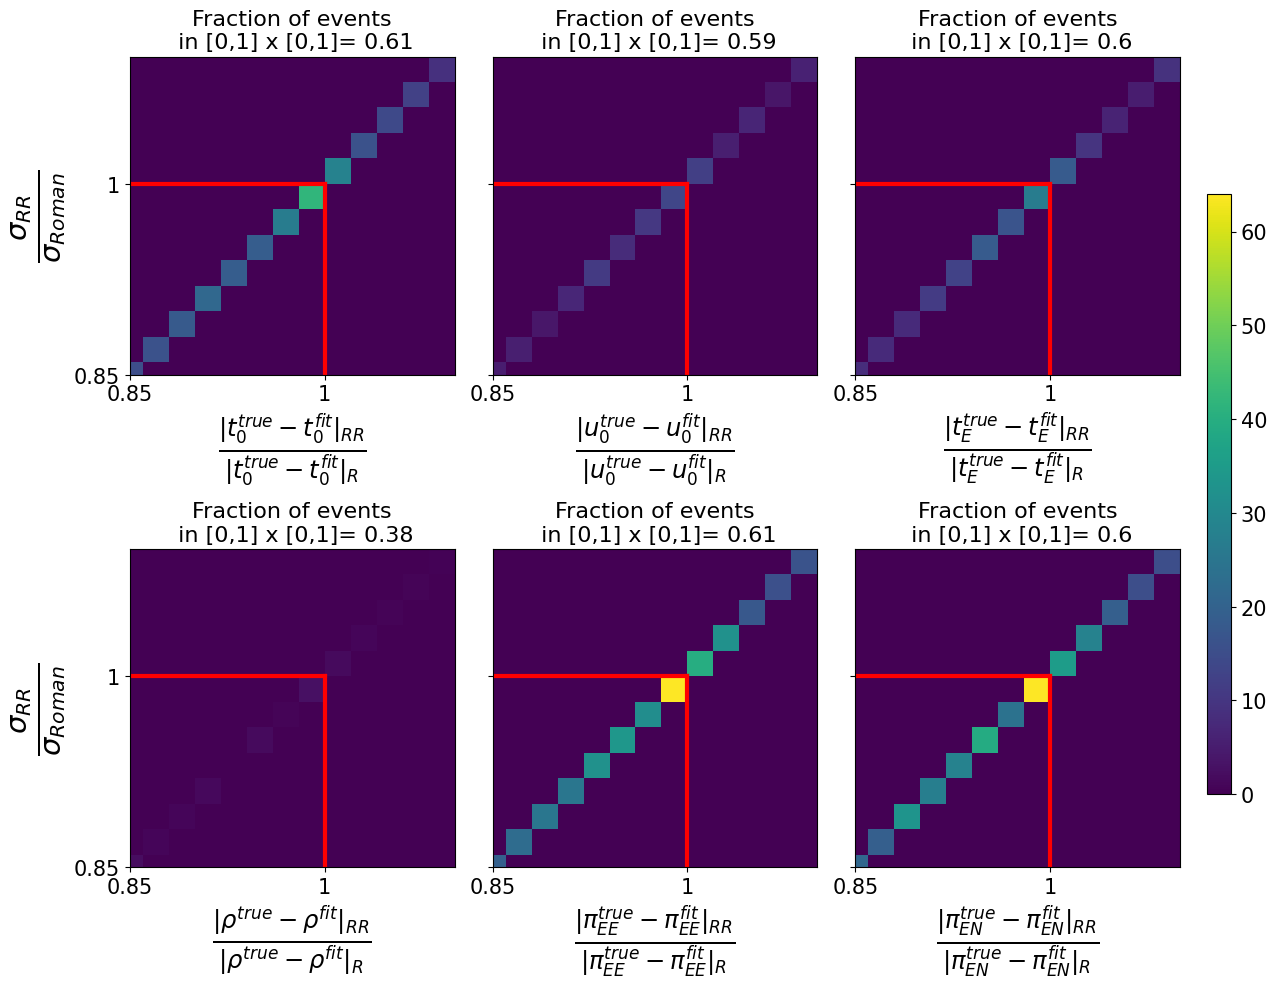

In [89]:
def plot_comparisons(err_ratio, residuals_ratio,opsim,model):
    fractions = []
    labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}'}
    # Define your data and properties as given in your code
    if 'PSPL' in model:
        properties = ('t0', 'u0', 'te', 'piEE', 'piEN')
    elif 'USPL' in model:
        properties = ('t0', 'u0', 'te','rho', 'piEE', 'piEN')
    else:
        properties = ('t0', 'u0', 'te','rho', 's', 'q', 'alpha', 'piEE', 'piEN')
    fig, axs = plt.subplots(2,3, figsize=(12, 10),sharey=True)
    cbar_axs = [fig.add_axes([1.01, 0.2, 0.02, 0.6])]#,  # Color bar for the first row
    Categories = {'B':'Roman gap but Rubin season','C':'Rubin gap but Roman season','D':'Overlap seasons'}
    n=1
    for i, p in enumerate(properties):
        row, col = divmod(i, 3)  # Calculate the row and column index for the current subplot
        # m1_ratio = met_1_ratio[met_1_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
        # print(len(m1_ratio))
        im = axs[row, col].hist2d(residuals_ratio[p]
                                  , err_ratio[p], bins=[np.arange(0, 1.2, 0.02), np.arange(0., 1.2, 0.02)])
        # print(len(m1_ratio[p]))
        label_m1 = r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{RR}}{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{R}}$'#+f'{labels[p]}'+'^{true}}$'#+r'$\frac{|'+f'{p}'+'^{true}-'+f'{p}'+'^{fit}|_{RR}}{'+f'{p}'+'^{true}}$'
        axs[row, col].set_xlabel(label_m1,fontsize=25)
        axs[row, col].set_xticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
        axs[row, col].set_yticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
        # Calculate the number of events in [0,1] x [0,1] square
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1
        axs[row, col].plot(np.linspace(0.,1,15),np.ones(15),color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.ones(15),np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.linspace(0.,1,15),np.ones(15)*0,color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.ones(15)*0,np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)

        df = err_ratio[(err_ratio[p]<y_max) & (err_ratio[p]>y_min)]
        # display(df)
#         # df0 = residuals_ratio[residuals_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
        number_in_square = len(df[(df[p] <x_max) & (df[p] >x_min)])/len(residuals_ratio)
        
#         # Label for the text annotation
        text_x = 1  # X-coordinate for the text
        text_y = 0.4  # Y-coordinate for the text (negative to go below the figure)
        text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
        axs[row, col].set_title(text, fontsize = 16)

        if col == 0:
            axs[row, col].set_ylabel(r'$\frac{ \sigma_{RR} }{\sigma_{Roman}}$',fontsize=30)

        axs[row, col].set_xlim(0.85,1.1)
        axs[row, col].set_ylim(0.85, 1.1)

        fig.colorbar(im[3], cax=cbar_axs[0])
        cbar = fig.colorbar(im[3], cax=cbar_axs[0])
        cbar.ax.tick_params(labelsize=15)
    # plt.suptitle(opsim  +f' {model} - '+Categories[cat],fontsize=30)    
    plt.tight_layout()
    # plt.savefig(f'/home/anibal/FIGURES_roman_rubin/{model}_{opsim}_{cat}.png')
    plt.show()

cat = 'B'
plot_comparisons(err_ratio, residuals_ratio, 'Baseline', 'USPL')

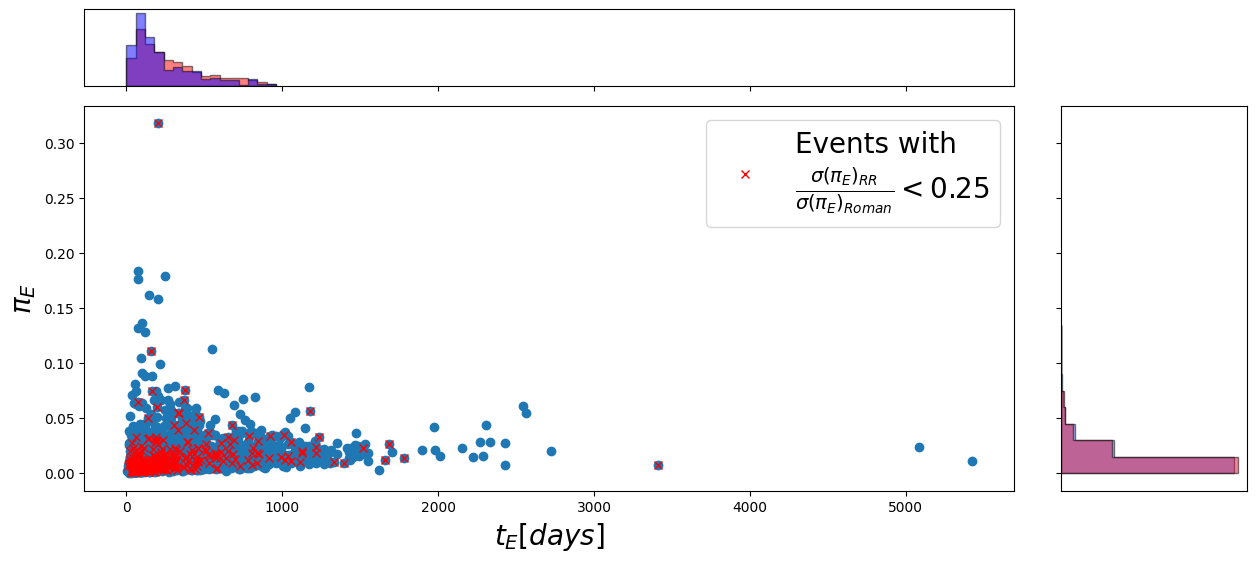

In [90]:
#x = residuals_ratio['te']
labelsparams = lambda p: labels[p]

label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'

label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'
fig, ax = plt.subplots(1, 1, figsize = (12, 5), sharey=True, gridspec_kw={'width_ratios': [1]})

q='te'
ax.plot(true['te'],true['piE'],marker='o',ls='')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.plot(true['te'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], true['piE'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])],marker='x',ls='',color='red',label='Events with\n'+r'$\frac{\sigma(\pi_E)_{RR}}{\sigma(\pi_E)_{Roman}}<0.25$')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.set_xlabel(r'$t_E [days]$',fontsize=20)
ax.set_ylabel(r'$\pi_E$',fontsize=20)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

# Histogram settings
#binwidth = 0.1
ax_histx.hist(true['te'], bins=np.arange(0, 1000, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
ax_histx.hist(true['te'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 1000, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='blue')

ax_histy.hist(true['piE'], bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')
ax_histy.hist(true['piE'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='crimson', orientation='horizontal')

#ax_histy.set_xscale("log")
# Remove ticks from inset histograms
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", left=False, labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
ax.legend(loc='best',fontsize=20)


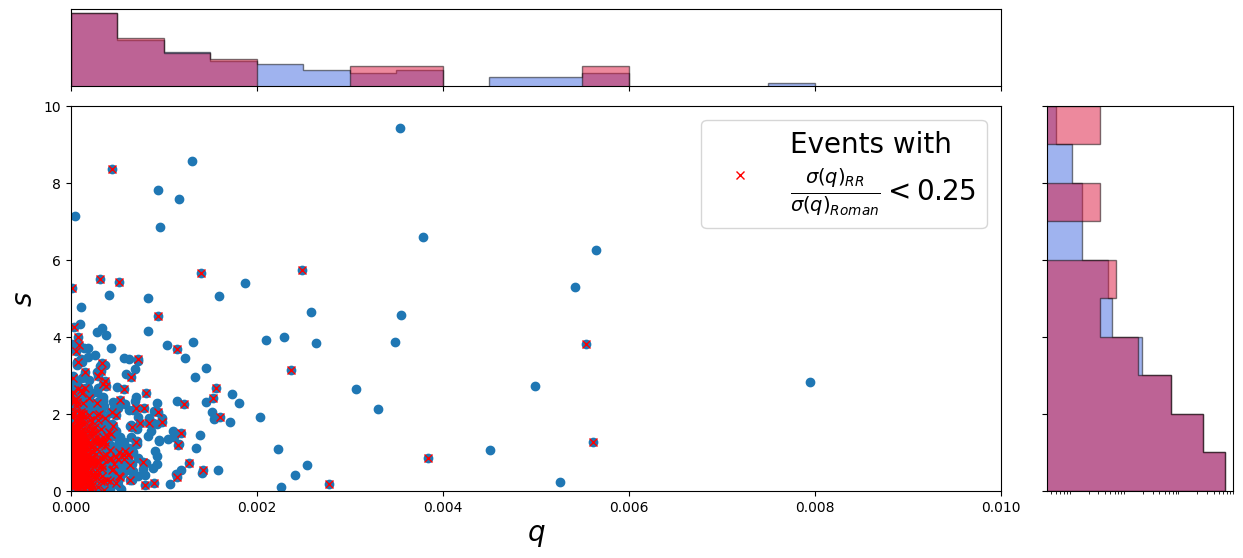

In [148]:
labelsparams = lambda p: labels[p]

label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'
label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'

fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1]})

q='te'
ax.plot(true['q'],true['s'],marker='o',ls='')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.plot(true['q'][true['Source'].isin(err_ratio['Source'][err_ratio['q']<0.25])], true['s'][true['Source'].isin(err_ratio['Source'][err_ratio['q']<0.25])],marker='x',ls='',color='red',label='Events with\n'+r'$\frac{\sigma(q)_{RR}}{\sigma(q)_{Roman}}<0.25$')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.set_xlabel(r'$q$',fontsize=20)
ax.set_ylabel(r'$s$',fontsize=20)
ax.set_xlim(0,0.01)
ax.set_ylim(0,10)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

# Histogram settings
#binwidth = 0.1
ax_histx.hist(true['q'], bins=np.arange(0, 0.01, 0.0005), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue')
ax_histx.hist(true['q'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 0.01, 0.0005), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='crimson')

ax_histy.hist(true['s'], bins=np.arange(0, 18, 1), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')
ax_histy.hist(true['s'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 18, 1), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='crimson', orientation='horizontal')

ax_histy.set_xscale("log")
ax_histx.set_yscale("log")
# Remove ticks from inset histograms
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", left=False, labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
ax.legend(loc='best',fontsize=20)

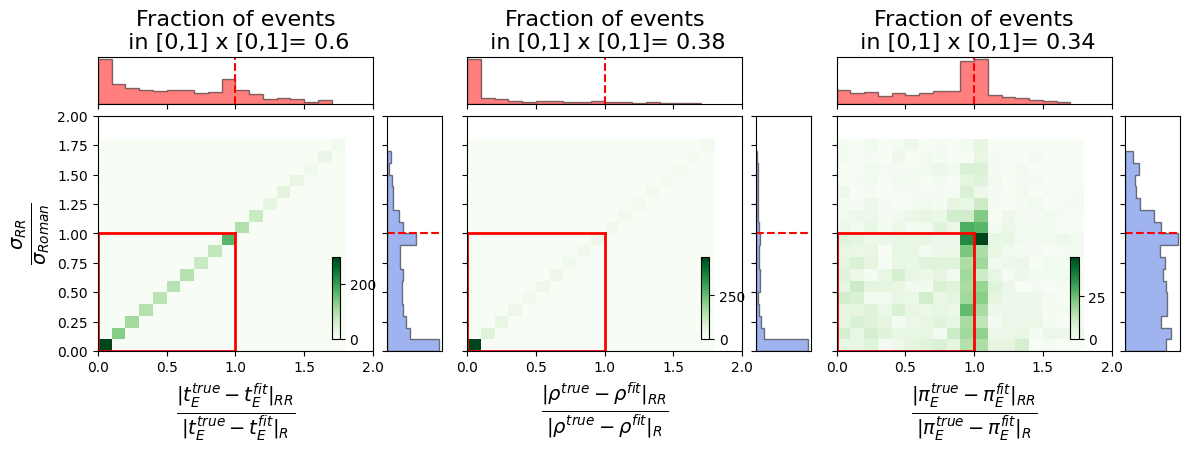

In [92]:
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piE':'\pi_{E}', 'piEN':'\pi_{EN}'}

def create_hist2d_with_marginals(ax, x, y, labels, p, first_col=False):
    # Main scatter plot
    hb = ax.hist2d(x, y, bins=(np.arange(0, 1.9, 0.1), np.arange(0, 1.9, 0.1)), cmap='Greens')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)

    # Create inset axes for the histograms
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

    # Histogram settings
    binwidth = 0.1
    ax_histx.hist(x, bins=np.arange(0, 1.8, binwidth), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
    ax_histy.hist(y, bins=np.arange(0, 1.8, binwidth), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')

    # Remove ticks from inset histograms
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", left=False, labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
    # ax_histy.set_yscale("log")
    # Add vertical and horizontal lines
    ax_histx.axvline(1, color='red', ls='--')
    ax_histy.axhline(1, color='red', ls='--')
    ax.axvline(1, ymin=0, ymax=0.5, lw=2, color='red')
    ax.axvline(0, ymin=0, ymax=0.5, lw=2, color='red')
    ax.axhline(0, xmin=0, xmax=0.5, lw=2, color='red')
    ax.axhline(1, xmin=0, xmax=0.5, lw=2, color='red')

    # Set labels with LaTeX formatting
    label_m1 = lambda p: r'$\frac{|' + f'{labels[p]}' + r'^{true}-' + f'{labels[p]}' + r'^{fit}|_{RR}}{|' + f'{labels[p]}' + r'^{true}-' + f'{labels[p]}' + r'^{fit}|_{R}}$'
    label_m2 = r'$\frac{\sigma_{RR}}{\sigma_{Roman}}$'

    ax.set_xlabel(label_m1(p), fontsize=20)
    
    # ax.set_xlabel("a",fontsize=20)
    if first_col:
        ax.set_ylabel(label_m2, fontsize=20)

    # Add a colorbar inside the main plot
    cax = ax.inset_axes([0.85, 0.05, 0.03, 0.35], transform=ax.transAxes)
    cbar = plt.colorbar(hb[3], cax=cax, orientation='vertical')
    # cax.set_yticks([0, 50, 1000])
    # cax.set_yticklabels([0, 100, 2000], fontsize=8)
    x_min=0
    x_max=1
    y_min=0
    y_max=1
    fil_x= x[(y<1)&(y>0)]
    filtered=fil_x[(fil_x<1)&(fil_x>0)]

    number_in_square = len(filtered)/len(y)
    text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
    ax.set_title(text, fontsize = 16)

# Example usage
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
x = residuals_ratio['te']
y = err_ratio['te']
x2 = residuals_ratio['rho']
y2 = err_ratio['rho']
x3 = residuals_ratio['piE']
y3 = err_ratio['piE']

create_hist2d_with_marginals(axes[0], x, y, labels, 'te', first_col=True)
create_hist2d_with_marginals(axes[1], x2, y2, labels, 'rho')
create_hist2d_with_marginals(axes[2], x3, y3, labels, 'piE')

plt.tight_layout()
plt.show()

The MSE is defined as 
$$MSE(\hat{\theta}) = bias(\hat{\theta}) + Var(\hat{\theta}) $$

In [93]:
# plt.hist(residuals_ratio['te'],bins=np.arange(0,2,0.1))

In [94]:
print(len(true))
print(len(fit_rr))
print(len(fit_roman))

2008
2008
2008


26.842629482071715


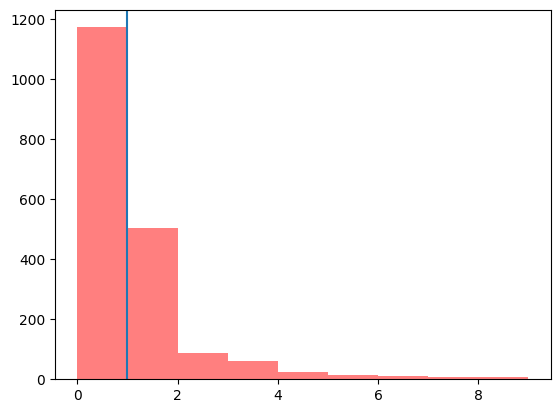

In [95]:
p='piE'

MSE_rr = abs(fit_rr[p]-true[p]) + fit_rr[p+'_err']**2
MSE_roman = abs(fit_roman[p]-true[p]) + fit_roman[p+'_err']**2
MSE_ratio = MSE_rr/MSE_roman
print(100*len(MSE_ratio[MSE_ratio<0.5])/len(MSE_ratio))
plt.hist(MSE_ratio,bins=np.arange(0,10,1),color='red',alpha=0.5)
plt.axvline(1)
# plt.hist(,bins=np.arange(0,0.05,0.001),alpha=0.5,color='blue')
# plt.hist()
plt.show()

### bias/true

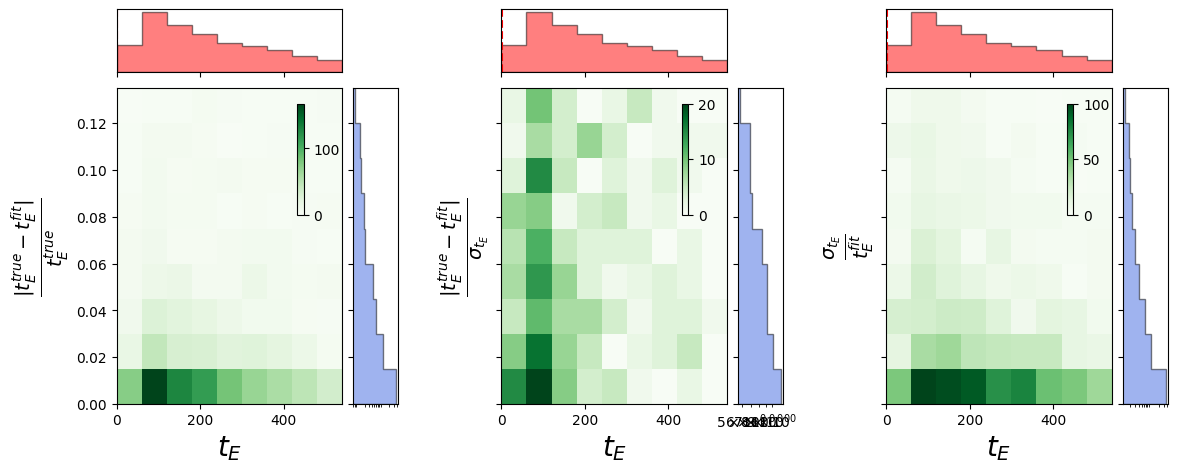

In [96]:
labelsparams = lambda p: labels[p]

label_m1 = lambda p: r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{'+f'{labels[p]}'+'^{true}'+'}$'
label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'
label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'

def create_hist2d_with_marginals(ax, x, y, ylabel_func,xlabel_func, p, first_col=False):
    # Main scatter plot
    hb = ax.hist2d(x, y, bins=(np.arange(0, 600, 60), np.arange(0, 0.15, 0.015)), cmap='Greens')
    # Create inset axes for the histograms
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    # Histogram settings
    binwidth = 0.1
    ax_histx.hist(x, bins=np.arange(0, 600, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
    ax_histy.hist(y, bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')
    ax_histy.set_xscale("log")
    # Remove ticks from inset histograms
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", left=False, labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
    # Add vertical and horizontal lines
    ax_histx.axvline(1, color='red', ls='--')
    ax_histy.axhline(1, color='red', ls='--')
    # Set labels with LaTeX formatting
    label_m1 = lambda p: r'$\frac{|' + f'{labels[p]}' + r'^{\text{true}}-' + f'{labels[p]}' + r'^{\text{fit}}|_{RR}}{|' + f'{labels[p]}' + r'^{\text{true}}-' + f'{labels[p]}' + r'^{\text{fit}}|_{R}}$'
    label_m2 = r'$\frac{\sigma_{RR}}{\sigma_{\text{Roman}}}$'

    ax.set_ylabel(ylabel_func(p), fontsize=20)
    ax.set_xlabel(f'${xlabel_func(p)}$', fontsize=20)
    cax = ax.inset_axes([0.8, 0.6, 0.03, 0.35], transform=ax.transAxes)
    cbar = plt.colorbar(hb[3], cax=cax, orientation='vertical')

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
x = residuals_ratio['te']
y = err_ratio['te']
x2 = residuals_ratio['rho']
y2 = err_ratio['rho']
x3 = residuals_ratio['piE']
y3 = err_ratio['piE']

p='te'
create_hist2d_with_marginals(axes[0], fit_rr[p], met_1_rr[p], label_m1, labelsparams, 'te', first_col=True)
create_hist2d_with_marginals(axes[1], fit_rr[p], met_2_rr[p], label_m2, labelsparams, 'te')
create_hist2d_with_marginals(axes[2], fit_rr[p], met_3_rr[p], label_m3, labelsparams, 'te')
# create_hist2d_with_marginals(axes[1], x2, y2, labels, 'rho')
# create_hist2d_with_marginals(axes[2], x3, y3, labels, 'piE')

plt.tight_layout()
plt.show()

In [97]:
# met_1_roman

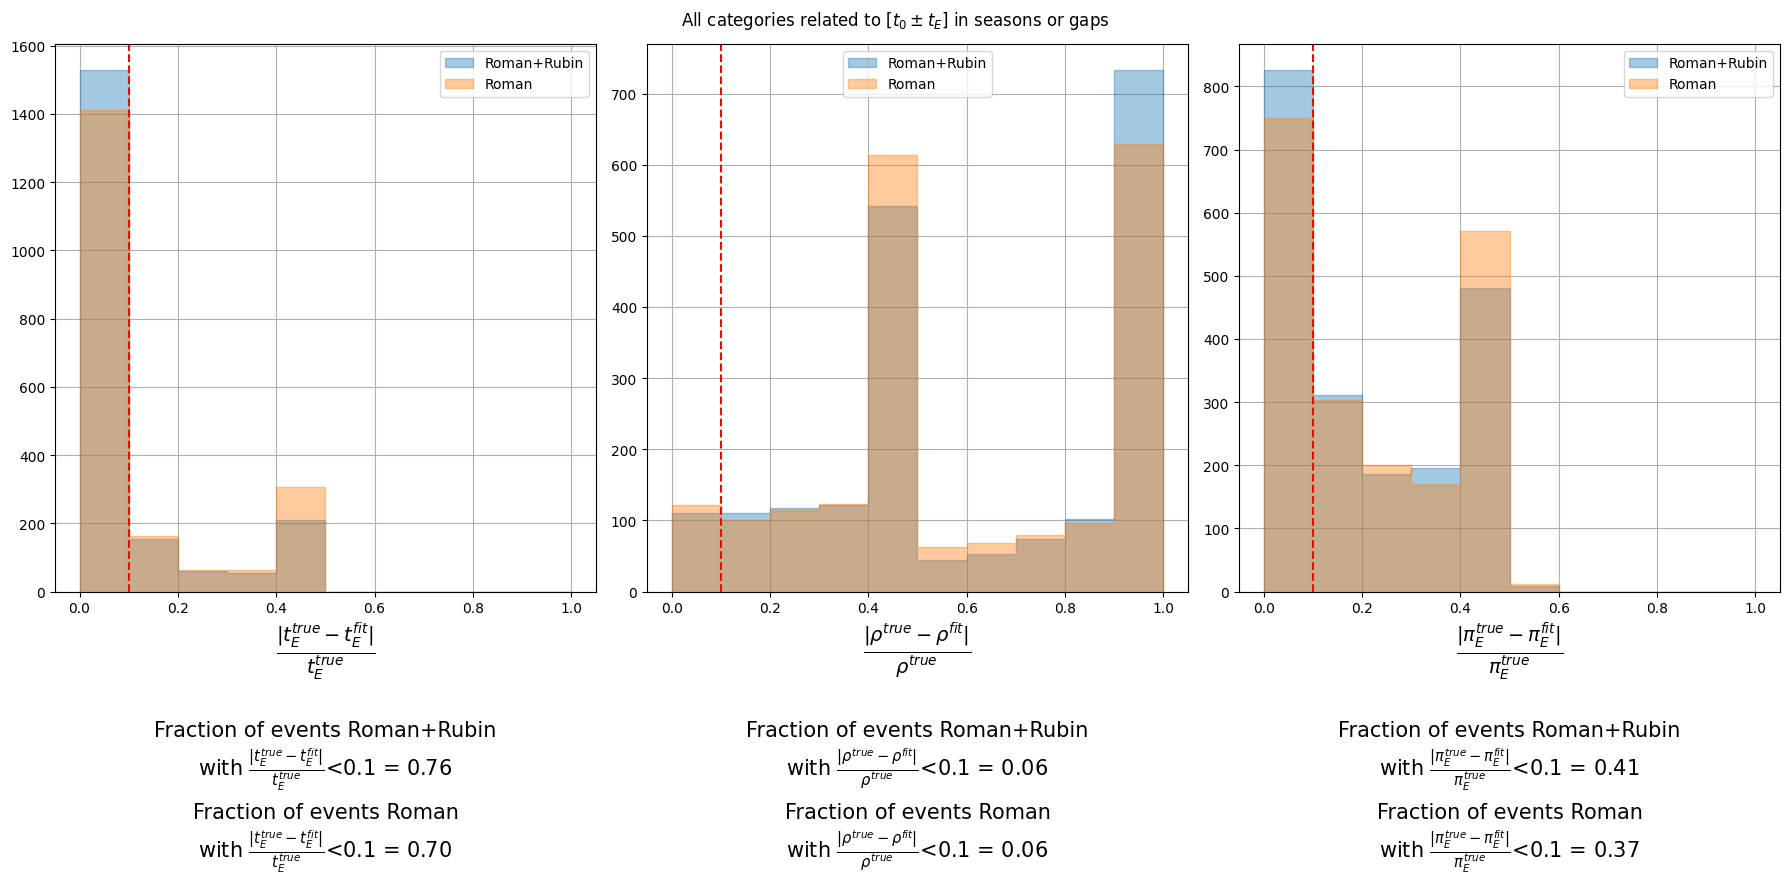

In [104]:

cats_labels = {'A': 'Overlap seasons Roman and Rubin', 'B': 'Roman gap and Rubin season','C': 'gap Roman and gap Rubin', 'D': 'Season Roman and gap Rubin'}
# Function to plot histograms and annotations
def plot_histogram(ax, data1, data2, xlabel, title):
    # ax.set_title(title)
    ax.hist(data1, bins=np.arange(0, 1.1, 0.1), fill=True, alpha=0.4, histtype='step', label='Roman+Rubin')
    ax.hist(data2, bins=np.arange(0, 1.1, 0.1), fill=True, alpha=0.4, histtype='step', label='Roman')
    ax.set_xlabel(xlabel, fontsize=20)
    ax.axvline(0.1, color='red', linestyle='--')
    ax.legend(loc='best')
    
    fraction_data1 = len(data1[data1 < 0.1]) / len(data1)
    fraction_data2 = len(data2[data2 < 0.1]) / len(data2)
    
    ax.annotate(f'Fraction of events Roman+Rubin\nwith {xlabel}<0.1 = {fraction_data1:.2f}', 
                xy=(0.5, -0.3), xycoords='axes fraction',
                ha='center', va='center', fontsize=15)
    ax.annotate(f'Fraction of events Roman\nwith {xlabel}<0.1 = {fraction_data2:.2f}', 
                xy=(0.5, -0.45), xycoords='axes fraction',
                ha='center', va='center', fontsize=15)

    

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Si quiero ver una categoria en particular
cat = 'D'
# plt.suptitle(f'Category: {cats_labels[cat]}')
plt.suptitle(f'All categories related to [$t_0 \pm t_E$] in seasons or gaps')
mask = met_1_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_1_rr[p], met_1_roman[p], label_m1(p), f'${labels[p]}$')

# Plot for 'rho'
q = 'rho'
plot_histogram(axes[1], met_1_rr[q], met_1_roman[q], label_m1(q), f'${labels[q]}$')

r = 'piE'
plot_histogram(axes[2], met_1_rr[r], met_1_roman[r], r'$\frac{|\pi_E^{true}-\pi_E^{fit}|}{\pi_E^{true}}$', f'$\pi_E$')

# Adjust layout for better spacing
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()

# Show the plot
plt.show()


### bias/sigma

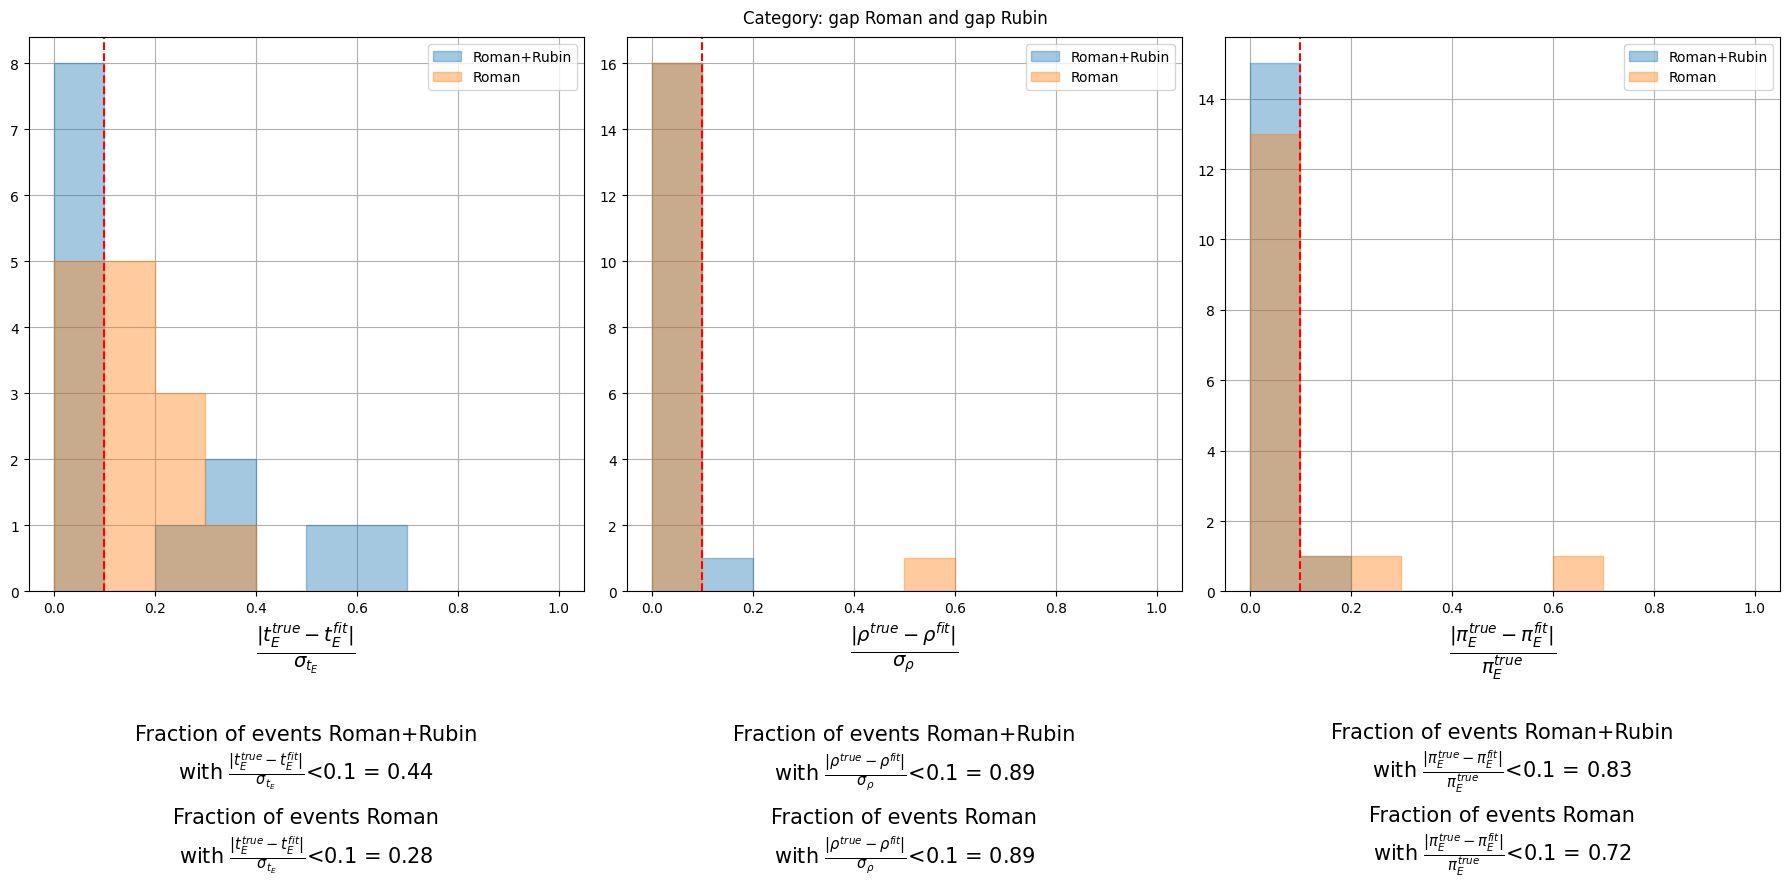

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
plt.suptitle(f'Category: {cats_labels[cat]}')
# plt.suptitle(f'All categories related to [$t_0 \pm t_E$] in seasons or gaps')
cat = 'D'
mask = met_2_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_2_rr[p][mask], met_2_roman[p][mask], label_m2(p), f'${labels[p]}$')

# Plot for 'rho'
q = 'rho'
plot_histogram(axes[1], met_2_rr[q][mask], met_2_roman[q][mask], label_m2(q), f'${labels[q]}$')

r = 'piE'
plot_histogram(axes[2], met_2_rr[r][mask], met_2_roman[r][mask], r'$\frac{|\pi_E^{true}-\pi_E^{fit}|}{\pi_E^{true}}$', f'$\pi_E$')
# plt.suptitle(f'Category: {cats_labels[cat]}')
# Adjust layout for better spacing
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()

# Show the plot
plt.show()

### relative error

In [39]:
# met_3_rr['q']

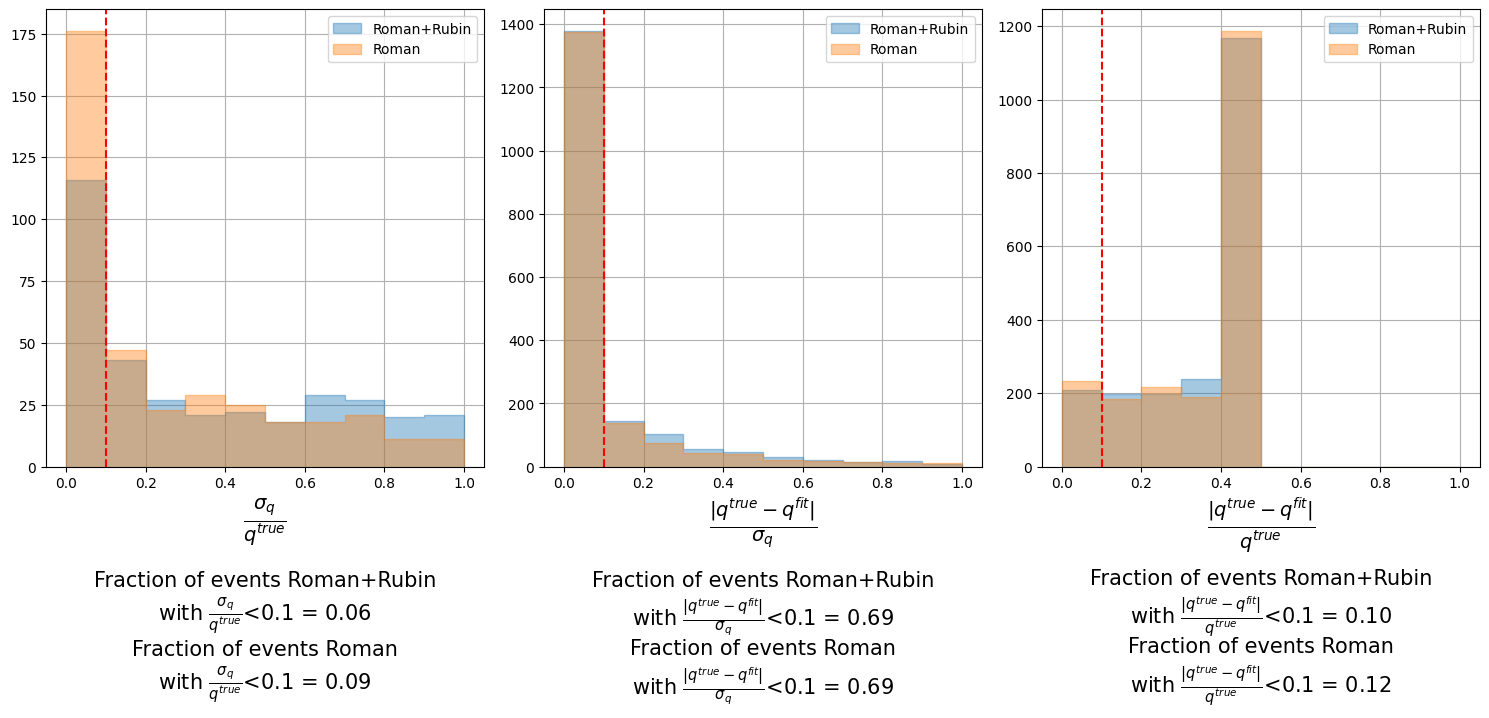

In [138]:

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

plot_histogram(axes[0], met_3_rr['q'], met_3_roman['q'], r'$\frac{\sigma_q}{q^{true}}$', f'$q$')
plot_histogram(axes[1], met_2_rr['q'], met_2_roman['q'], r'$\frac{|q^{true}-q^{fit}|}{\sigma_q}$', f'$q$')
plot_histogram(axes[2], met_1_rr['q'], met_1_roman['q'], r'$\frac{|q^{true}-q^{fit}|}{q^{true}}$', f'$q$')

axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()

# Show the plot
plt.show()

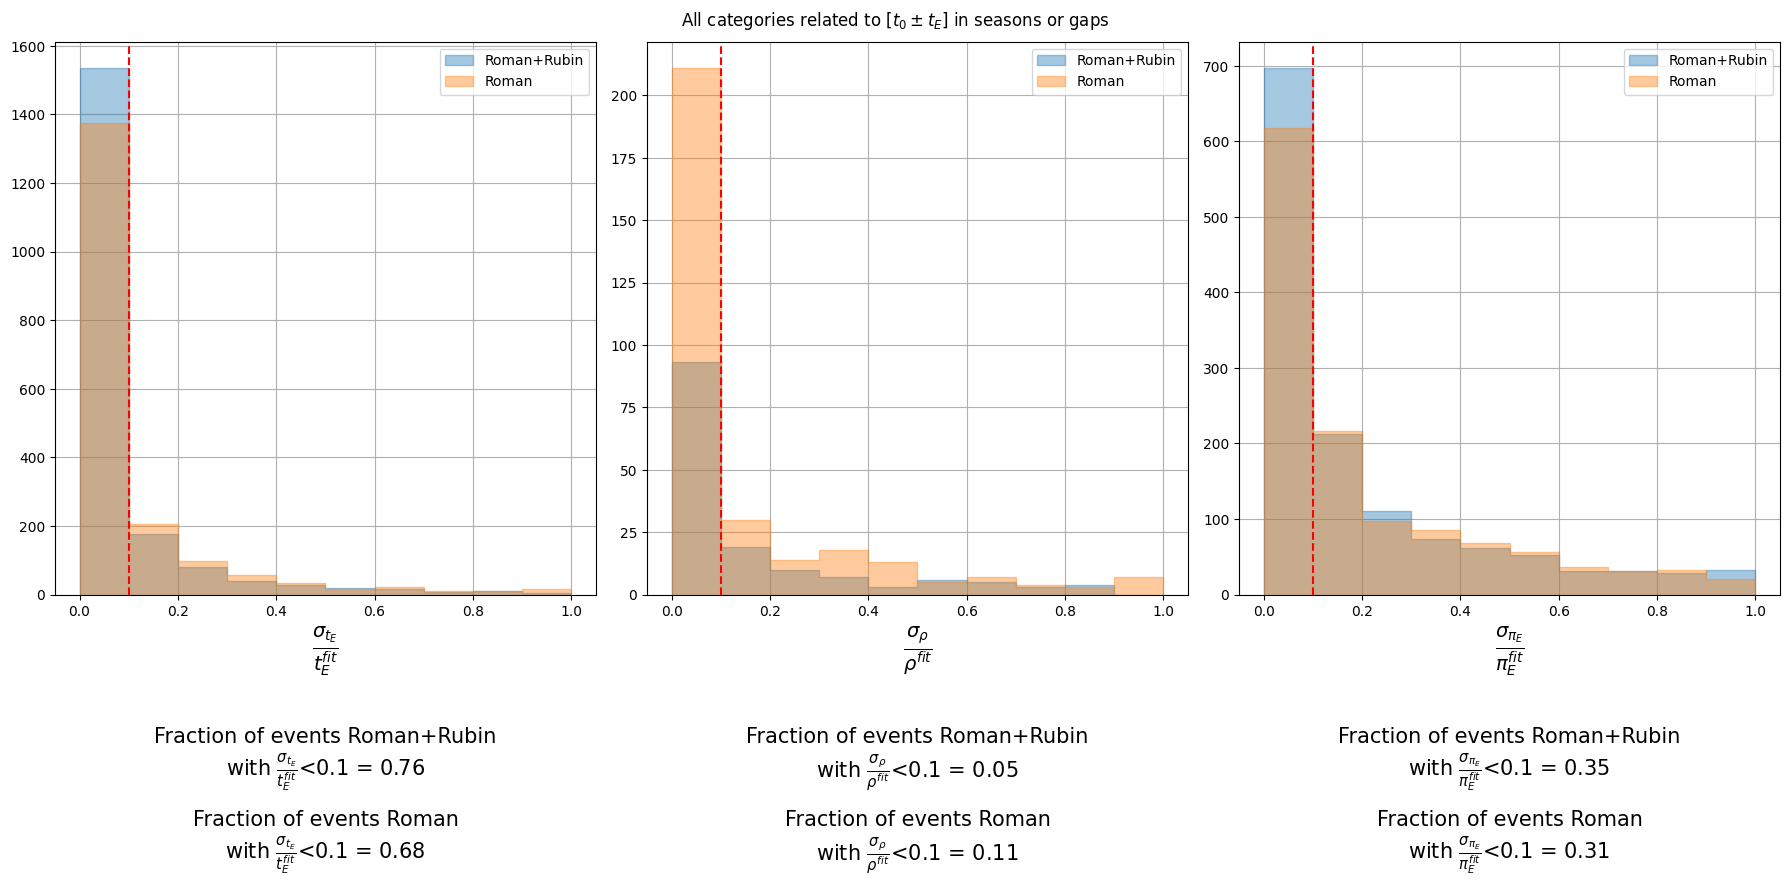

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

cat = 'D'
# plt.suptitle(f'Category: {cats_labels[cat]}')
plt.suptitle(f'All categories related to [$t_0 \pm t_E$] in seasons or gaps')
mask = met_3_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_3_rr[p], met_3_roman[p], label_m3(p), f'${labels[p]}$')

# Plot for 'rho'
q = 'rho'
plot_histogram(axes[1], met_3_rr[q], met_3_roman[q], label_m3(q), f'${labels[q]}$')

r = 'piE'
plot_histogram(axes[2], met_3_rr[r], met_3_roman[r], r'$\frac{\sigma_{\pi_E}}{\pi_E^{fit}}$', f'$\pi_E$')

# Adjust layout for better spacing
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()

# Show the plot
plt.show()

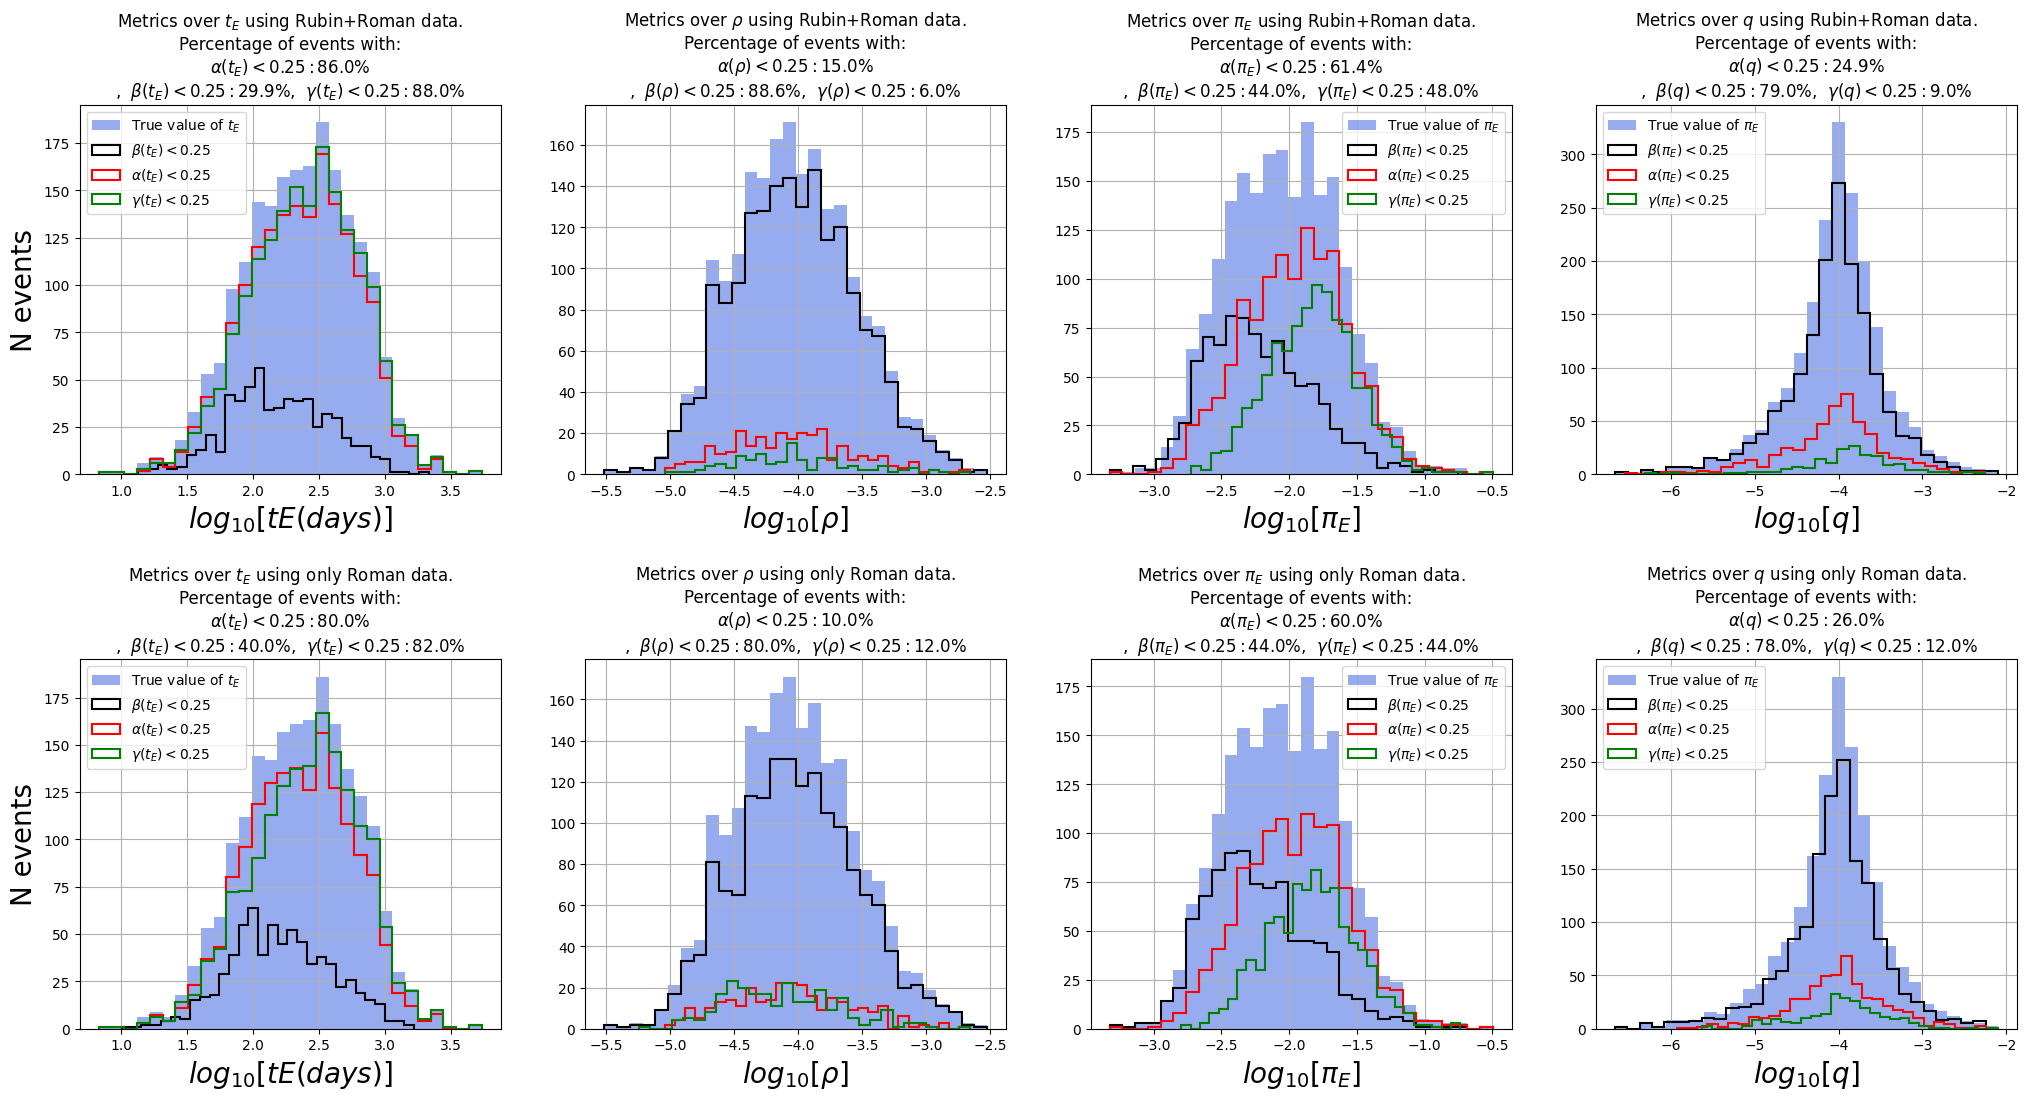

In [94]:
%matplotlib inline
plt.close('all')
# plt.figure(figsize=(8,6))
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
axes[0,0].hist(np.log10(true['te']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_2_rr['te']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_1_rr['te']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_3_rr['te']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,0].set_xlabel(r'$log_{10}[tE(days)]$',fontsize=20)
axes[0,0].set_ylabel('N events',fontsize=20)
axes[0,0].grid(True)

axes[0,1].hist(np.log10(true['rho']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_2_rr['rho']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_1_rr['rho']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_3_rr['rho']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,1].set_xlabel(r'$log_{10}[\rho]$',fontsize=20)
axes[1,0].set_ylabel('N events',fontsize=20)
axes[0,1].grid(True)
# plt.show()
# plt.close('all')
# plt.figure(figsize=(8,6))
axes[0,2].hist(np.log10(true['piE']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_2_rr['piE']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_1_rr['piE']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_3_rr['piE']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,2].set_xlabel(r'$log_{10}[\pi_E]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[0,2].grid(True)
axes[0,2].legend(loc='best')

axes[0,3].hist(np.log10(true['q']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[0,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_2_rr['q']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[0,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_1_rr['q']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[0,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_3_rr['q']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,3].set_xlabel(r'$log_{10}[q]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[0,3].grid(True)
axes[0,3].legend(loc='best')


axes[0,0].legend(loc='best')
# plt.suptitle('Roman and Rubin lightcurves',fontsize=18)
# plt.show()
# 
# plt.close('all')
# plt.figure(figsize=(8,6))
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[1,0].hist(np.log10(true['te']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_2_roman['te']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_1_roman['te']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_3_roman['te']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,0].set_xlabel(r'$log_{10}[tE(days)]$',fontsize=20)
# axes[1,0].set_ylabel('N events',fontsize=20)
axes[1,0].grid(True)


axes[1,1].hist(np.log10(true['rho']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_2_roman['rho']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_1_roman['rho']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_3_roman['rho']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,1].set_xlabel(r'$log_{10}[\rho]$',fontsize=20)
# axes[1,1].set_ylabel('N events',fontsize=20)
axes[1,1].grid(True)
# plt.show()
# plt.close('all')
# plt.figure(figsize=(8,6))
axes[1,2].hist(np.log10(true['piE']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_2_roman['piE']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_1_roman['piE']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_3_roman['piE']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,2].set_xlabel(r'$log_{10}[\pi_E]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[1,2].grid(True)
axes[1,2].legend(loc='best')



axes[1,3].hist(np.log10(true['q']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[1,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_2_roman['q']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[1,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_1_roman['q']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[1,3].hist(np.log10(true['q'][true['Source'].isin(true['Source'][met_3_roman['q']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.avline(68.2,color='red')
# plt.yscale('log')
axes[1,3].set_xlabel(r'$log_{10}[q]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[1,3].grid(True)
axes[1,3].legend(loc='best')

axes[1,0].legend(loc='best')
# plt.suptitle('Roman lightcurves',fontsize=18)
axes[1,0].set_title(r'Metrics over $t_E$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(t_E)<0.25:$"+f"{100*round(len(met_1_roman['te'][met_1_roman['te']<0.25])/len(true),2)}%"+'\n'+r',  $\beta(t_E)<0.25:$'+f"{100*round(len(met_2_roman['te'][met_2_roman['te']<0.25])/len(true),1)}%"+r',  $\gamma(t_E)<0.25:$'+f"{100*round(len(met_3_roman['te'][met_3_roman['te']<0.25])/len(true),2)}%")
axes[0,0].set_title(r'Metrics over $t_E$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(t_E)<0.25:$"+f"{100*round(len(met_1_rr['te'][met_1_rr['te']<0.25])/len(true),2)}%"+'\n'+r',  $\beta(t_E)<0.25:$'+f"{100*round(len(met_2_rr['te'][met_2_rr['te']<0.25])/len(true),3)}%"+r',  $\gamma(t_E)<0.25:$'+f"{100*round(len(met_3_rr['te'][met_3_rr['te']<0.25])/len(true),2)}%")

axes[0,2].set_title(r'Metrics over $\pi_E$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\pi_E)<0.25:$"+f"{100*round(len(met_1_rr['piE'][met_1_rr['piE']<0.25])/len(true),3)}%"+'\n'+r',  $\beta(\pi_E)<0.25:$'+f"{100*round(len(met_2_rr['piE'][met_2_rr['piE']<0.25])/len(true),2)}%"+r',  $\gamma(\pi_E)<0.25:$'+f"{100*round(len(met_3_rr['piE'][met_3_rr['piE']<0.25])/len(true),2)}%")
axes[1,2].set_title(r'Metrics over $\pi_E$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\pi_E)<0.25:$"+f"{100*round(len(met_1_roman['piE'][met_1_roman['piE']<0.25])/len(true),1)}%"+'\n'+r',  $\beta(\pi_E)<0.25:$'+f"{100*round(len(met_2_roman['piE'][met_2_roman['piE']<0.25])/len(true),2)}%"+r',  $\gamma(\pi_E)<0.25:$'+f"{100*round(len(met_3_roman['piE'][met_3_roman['piE']<0.25])/len(true),2)}%")

axes[1,1].set_title(r'Metrics over $\rho$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\rho)<0.25:$"+f"{100*round(len(met_1_roman['rho'][met_1_roman['rho']<0.25])/len(true),1)}%"+'\n'+r',  $\beta(\rho)<0.25:$'+f"{100*round(len(met_2_roman['rho'][met_2_roman['rho']<0.25])/len(true),1)}%"+r',  $\gamma(\rho)<0.25:$'+f"{100*round(len(met_3_roman['rho'][met_3_roman['rho']<0.25])/len(true),2)}%")
axes[0,1].set_title(r'Metrics over $\rho$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\rho)<0.25:$"+f"{100*round(len(met_1_rr['rho'][met_1_rr['rho']<0.25])/len(true),2)}%"+'\n'+r',  $\beta(\rho)<0.25:$'+f"{100*round(len(met_2_rr['rho'][met_2_rr['rho']<0.25])/len(true),3)}%"+r',  $\gamma(\rho)<0.25:$'+f"{100*round(len(met_3_rr['rho'][met_3_rr['rho']<0.25])/len(true),2)}%")

axes[0,3].set_title(r'Metrics over $q$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(q)<0.25:$"+f"{100*round(len(met_1_rr['q'][met_1_rr['q']<0.25])/len(true),3)}%"+'\n'+r',  $\beta(q)<0.25:$'+f"{100*round(len(met_2_rr['q'][met_2_rr['q']<0.25])/len(true),2)}%"+r',  $\gamma(q)<0.25:$'+f"{100*round(len(met_3_rr['q'][met_3_rr['q']<0.25])/len(true),2)}%")
axes[1,3].set_title(r'Metrics over $q$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(q)<0.25:$"+f"{100*round(len(met_1_roman['q'][met_1_roman['q']<0.25])/len(true),2)}%"+'\n'+r',  $\beta(q)<0.25:$'+f"{100*round(len(met_2_roman['q'][met_2_roman['q']<0.25])/len(true),2)}%"+r',  $\gamma(q)<0.25:$'+f"{100*round(len(met_3_roman['q'][met_3_roman['q']<0.25])/len(true),2)}%")
plt.show()

# mass estimation

In [ ]:
6841-5000

In [ ]:
true[true["categories"]=='D']

In [ ]:
# met_3_rr['Source'][met_3_rr['Source']<10000].iloc[0]

$\theta_E\pi_E=\pi_{rel}$
$$M=\frac{\theta_E}{\kappa\pi_{E}}=\frac{\theta_E}{\kappa\sqrt{\pi_{EE}^2+\pi_{EN}^2}} $$

$$\frac{\partial M}{\partial \theta_E}=\frac{1}{\kappa\sqrt{\pi_{EE}^2+\pi_{EN}^2}}=\frac{1}{\kappa\pi_{E}} $$
$$\frac{\partial M}{\partial \pi_{EE}}=-\frac{\theta_E \pi_{EE}}{\kappa[\pi_{EE}^2+\pi_{EN}^2]^{3/2}}=-\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}} $$
$$\frac{\partial M}{\partial \pi_{EN}}=-\frac{\theta_E\pi_{EN}}{\kappa[\pi_{EE}^2+\pi_{EN}^2]^{3/2}} =-\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}}$$


$$\sigma_M^2 = \left(\frac{\partial M}{\partial \theta_E} \sigma_{\theta_{E}}\right)^2 + \left(\frac{\partial M}{\partial \pi_{EE}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\partial M}{\partial \pi_{EN}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \pi_{EN}} cov(\pi_{EN},\pi_{EE})+ \frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \theta_E}cov(\pi_{EE},\theta_{E})+ \frac{\partial M}{\partial \pi_{EN}}\frac{\partial M}{\partial \theta_E}cov(\pi_{EN},\theta_{E})$$
if we consider $cov(\theta_E,\pi_{EE})=0$ , $cov(\theta_E,\pi_{EN})=0$
$$\sigma_M^2 = \left(\frac{\partial M}{\partial \theta_E} \sigma_{\theta_{E}}\right)^2 + \left(\frac{\partial M}{\partial \pi_{EE}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\partial M}{\partial \pi_{EN}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \pi_{EN}} cov(\pi_{EN},\pi_{EE})$$

$$\sigma_M^2 = \left(\frac{\theta_E}{\kappa\pi_{E}} 0.1\right)^2 + \left(\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}}\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}} cov(\pi_{EN},\pi_{EE})$$

$$\sigma_M^2 = M^2\left[\left( 0.1\right)^2 + \left(\frac{ \pi_{EE}}{\pi_{E}^{2}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{ \pi_{EN}}{\pi_{E}^{2}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{ \pi_{EE}}{\pi_{E}^{2}}\frac{ \pi_{EN}}{\pi_{E}^{2}} cov(\pi_{EN},\pi_{EE})\right]$$

$$\sigma_M = M\sqrt{\left[\left( 0.1\right)^2 + \left(\frac{ \pi_{EE}}{\pi_{E}^{2}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{ \pi_{EN}}{\pi_{E}^{2}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{ \pi_{EE}}{\pi_{E}^{2}}\frac{ \pi_{EN}}{\pi_{E}^{2}} cov(\pi_{EN},\pi_{EE})\right]}$$


In [ ]:
# Define constants
# aconv = (180 * 60 * 60 * 1000) / math.pi
# c = const.c
# G = const.G
# k = 4 * G / (c ** 2)
# # Initialize lists to store results
# err_rel_M = []
# M_fit_list_rr = []
# M_fit_list_roman = []
# M_true_list = []
# error_m_rr = []
# error_m_roman = []

# def calculate_mass_and_error(fit_params, thetaE):
#     # print(fit_params['piE'].values[0])
#     piE_fit = fit_params['piE'].values[0] * (1 / u.kpc)
    
#     piEE_fit = fit_params['piEE'].values[0] * (1 / u.kpc)
#     piEN_fit = fit_params['piEN'].values[0] * (1 / u.kpc)

#     sigma_piee = fit_params['piEE_err'].values[0] * (1 / u.kpc)
#     sigma_pien = fit_params['piEN_err'].values[0] * (1 / u.kpc)
#     # print(piE_fit,piEE_fit,piEN_fit,sigma_piee,sigma_pien)
#     # Calculate the fitted mass
#     M_fit = ((thetaE / aconv**2) / (k * piE_fit)).decompose().to('M_sun')
#     # Derivatives for error propagation
#     dm_dpiee = ((thetaE * (-piEE_fit) / aconv**2) / (k * piE_fit**3)).decompose()
#     dm_dpien = ((thetaE * (-piEN_fit) / aconv**2) / (k * piE_fit**3)).decompose()
#     dm_dthetaE = ((1  / aconv**2) / (k * piE_fit)).decompose()
#     # Quadratic terms for the error
#     quad_terms =  (dm_dpiee * sigma_piee)**2 + (dm_dpien * sigma_pien)**2 + (dm_dthetaE * 0.1 * thetaE)**2
#     # Covariance terms for the error
#     cov_terms = 2*dm_dpiee * dm_dpien * fit_params['cov_piEE_piEN'].values[0] * (1 / u.kpc)**2
#     # print(cuad_terms, cov_terms)
#     # Total error in mass
#     sigma_m = quad_terms + cov_terms

#     # print('mass: ',M_fit.value,'sigma_m', np.sqrt(sigma_m).to('M_sun').value)
#     # print('relative error: ',np.sqrt(sigma_m).to('M_sun').value/M_fit.value)
#     return M_fit.value, np.sqrt(sigma_m).to('M_sun').value

# # Loop through each event in met_3_rr

# for i in tqdm(range(len(met_3_rr[met_3_rr['Source']<10000].values))):
#     event_good_metric = met_3_rr['Source'][met_3_rr['Source']<10000].iloc[i]
#     # print(event_good_metric)
#     # Determine the file and row index for the event
#     nset = int(event_good_metric / 5000)
#     # print(nset)
#     nsource = int(event_good_metric - nset * 5000)
#     # Read the TRILEGAL parameters for the event
#     trilegal_params = pd.read_csv(f'/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv').iloc[nsource]
#     # Extract necessary parameters
#     Rstar = trilegal_params['radius'] * u.R_sun
#     DS = trilegal_params['D_S'] * u.pc
#     DL = trilegal_params['D_L'] * u.pc
#     pi_rel = ((1 / DL) - (1 / DS))
#     theta_s = np.arctan(Rstar / DS).decompose().to('mas').value
#     thetaE = theta_s / trilegal_params['rho']
#     # print('thetaE',thetaE)
#     piEE = trilegal_params['piEE']
#     piEN = trilegal_params['piEN']
#     piE = np.sqrt(piEE**2 + piEN**2) * (1 / u.kpc)
#     # Calculate the true mass
#     M_true = ((thetaE / aconv**2) / (k * piE)).decompose().to('M_sun')
#     # Append true mass to the list
#     M_true_list.append(M_true.value)
    
#     # Calculate mass and error for Rubin
#     # print()
#     M_fit_rr, sigma_m_rr = calculate_mass_and_error(fit_rr[fit_rr['Source']==event_good_metric], thetaE)
#     M_fit_list_rr.append(M_fit_rr)
#     error_m_rr.append(sigma_m_rr)
    
#     # Calculate mass and error for Roman
#     M_fit_roman, sigma_m_roman = calculate_mass_and_error(fit_roman, thetaE)
#     M_fit_list_roman.append(M_fit_roman)
#     error_m_roman.append(sigma_m_roman)
    # # print('-------------------------------------------')

In [142]:
# Define constants
aconv = (180 * 60 * 60 * 1000) / math.pi
c = const.c
G = const.G
k = 4 * G / (c ** 2)
# Initialize lists to store results
err_rel_M = []
M_fit_list_rr = []
M_fit_list_roman = []
M_true_list = []
error_m_rr = []
error_m_roman = []

def calculate_mass_and_error(fit_params, thetaE):
    piE_fit = fit_params['piE'].values[0] * (1 / u.kpc)
    
    piEE_fit = fit_params['piEE'].values[0] * (1 / u.kpc)
    piEN_fit = fit_params['piEN'].values[0] * (1 / u.kpc)

    sigma_piee = fit_params['piEE_err'].values[0] * (1 / u.kpc)
    sigma_pien = fit_params['piEN_err'].values[0] * (1 / u.kpc)

    # Calculate the fitted mass
    M_fit = ((thetaE / aconv**2) / (k * piE_fit)).decompose().to('M_sun')
    # Derivatives for error propagation
    dm_dpiee = ((thetaE * (-piEE_fit) / aconv**2) / (k * piE_fit**3)).decompose()
    dm_dpien = ((thetaE * (-piEN_fit) / aconv**2) / (k * piE_fit**3)).decompose()
    dm_dthetaE = ((1  / aconv**2) / (k * piE_fit)).decompose()
    # Quadratic terms for the error
    cuad_terms =  (dm_dpiee * sigma_piee)**2 + (dm_dpien * sigma_pien)**2 + (dm_dthetaE * 0.1 * thetaE)**2
    # Covariance terms for the error
    cov_terms = 2*dm_dpiee * dm_dpien * fit_params['cov_piEE_piEN'].values[0] * (1 / u.kpc)**2
    # print(cuad_terms, cov_terms)
    # Total error in mass
    sigma_m = cuad_terms + cov_terms
    # print(np.sqrt(sigma_m).to('M_sun').value/M_fit.value)
    # print(M_fit.value, np.sqrt(sigma_m).to('M_sun').value)
    return M_fit.value, np.sqrt(sigma_m).to('M_sun').value

# Loop through each event in met_3_rr

for i in tqdm(range(len(met_3_rr.values))):
    event_good_metric = met_3_rr['Source'].iloc[i]
    # Determine the file and row index for the event
    nset = int(event_good_metric / 5000)
    # print(nset)
    nsource = int(event_good_metric - nset * 5000)
    # Read the TRILEGAL parameters for the event
    trilegal_params = pd.read_csv(f'/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv').iloc[nsource]
    # Extract necessary parameters
    Rstar = trilegal_params['radius'] * u.R_sun
    DS = trilegal_params['D_S'] * u.pc
    DL = trilegal_params['D_L'] * u.pc
    pi_rel = ((1 / DL) - (1 / DS))
    theta_s = np.arctan(Rstar / DS).decompose().to('mas').value
    thetaE = theta_s / trilegal_params['rho']
    piEE = trilegal_params['piEE']
    piEN = trilegal_params['piEN']
    piE = np.sqrt(piEE**2 + piEN**2) * (1 / u.kpc)
    # Calculate the true mass
    M_true = ((thetaE / aconv**2) / (k * piE)).decompose().to('M_sun')
    # Append true mass to the list
    M_true_list.append(M_true.value)
    
    # Calculate mass and error for Rubin
    M_fit_rr, sigma_m_rr = calculate_mass_and_error(fit_rr[fit_rr['Source']==event_good_metric], thetaE)
    M_fit_list_rr.append(M_fit_rr)
    error_m_rr.append(sigma_m_rr)
    
    # Calculate mass and error for Roman
    M_fit_roman, sigma_m_roman = calculate_mass_and_error(fit_roman[fit_roman['Source']==event_good_metric], thetaE)
    M_fit_list_roman.append(M_fit_roman)
    error_m_roman.append(sigma_m_roman)

  0%|          | 0/2008 [00:00<?, ?it/s]

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: i

Para hallar la masa del planeta usamos $q=\frac{M_p}{M_s}$ y la masa total que derivamos aca $M_T=M_p+M_s$ $$M_p =\frac{ M_T q}{q+1}$$

In [ ]:
# 933-415

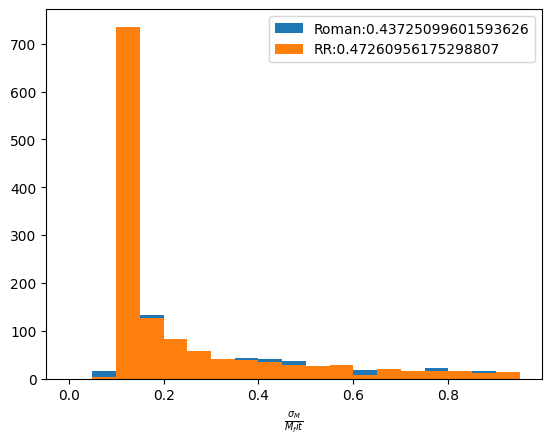

In [143]:
err_rel_roman = np.array(error_m_roman)/ np.array(M_fit_list_roman)
err_rel_rr = np.array(error_m_rr)/ np.array(M_fit_list_rr)
# print(min(err_rel_roman),min(err_rel_rr))
plt.hist(err_rel_roman,bins=np.arange(0,1,0.05),label='Roman:'+f'{len(err_rel_roman[err_rel_roman<0.25])/len(err_rel_roman)}')
plt.hist(err_rel_rr,bins=np.arange(0,1,0.05),label='RR:'+f'{len(err_rel_rr[err_rel_rr<0.25])/len(err_rel_rr)}')

plt.xlabel(r'$\frac{\sigma_M}{M_fit}$')
# plt.ylabel(r'$M_{fit}$')
plt.legend(loc='best')

In [ ]:
# len(M_fit_list_rr)

In [ ]:
# plt.hist(M_true_list,color='red')
# plt.hist(M_fit_list_roman,color='blue',alpha=0.5)
# plt.hist(M_fit_list_rr,color='green',alpha=0.5)

In [ ]:
# error_m_roman

In [ ]:
# i = 0 
# print(true["q"].iloc[i])
# print(M_true_list[i])
# print(M_fit_list_rr[i])
# print(M_fit_list_roman[i])

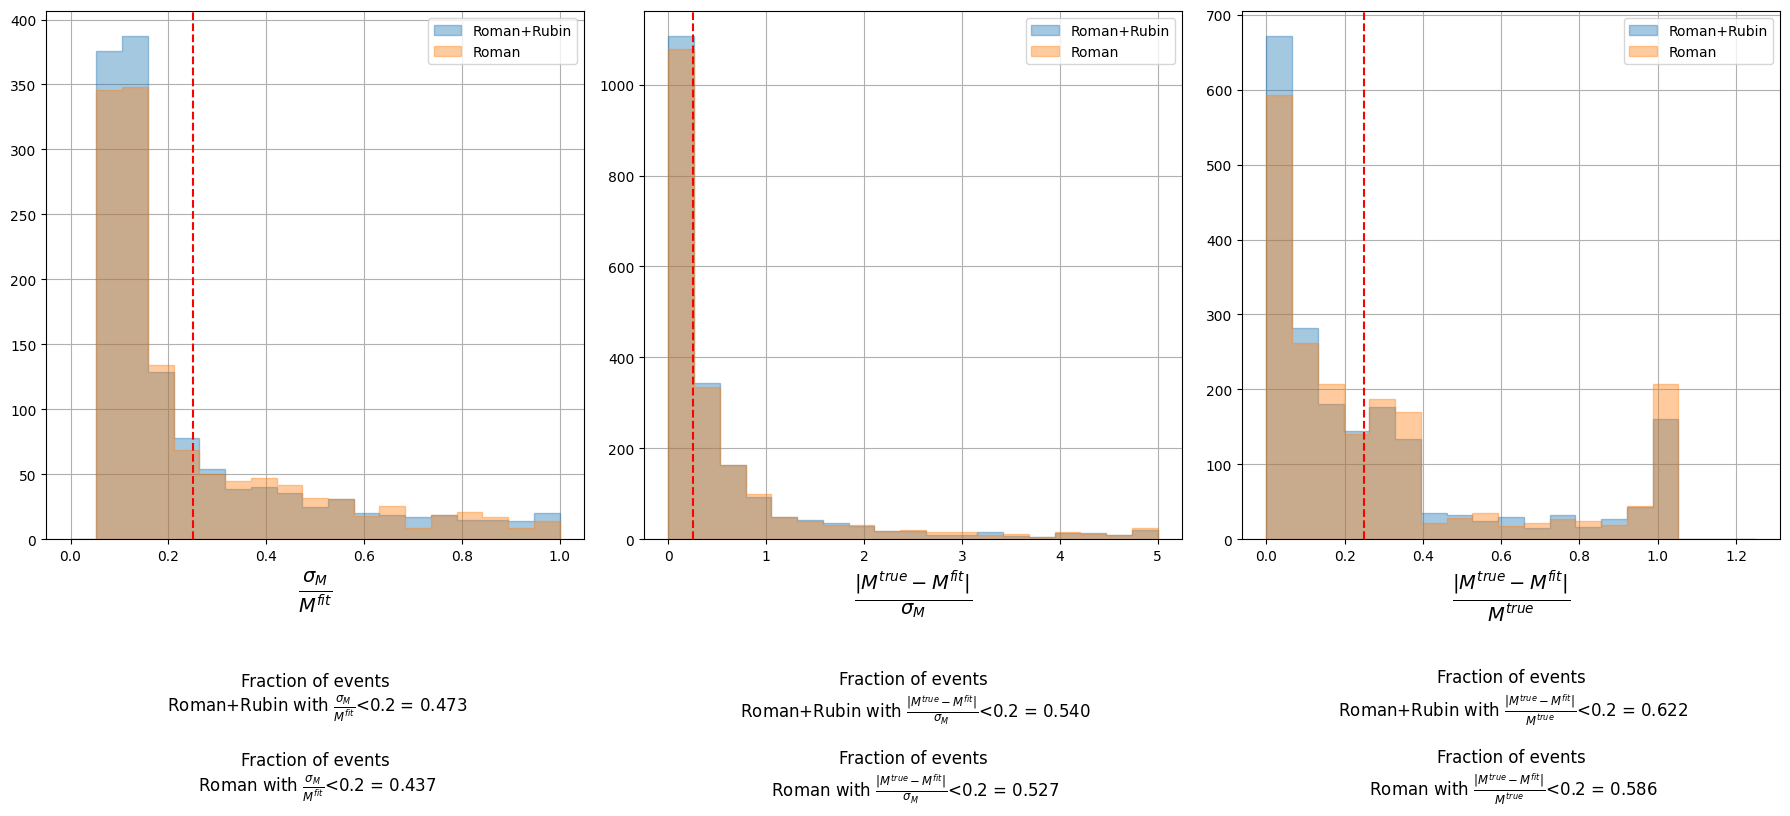

In [144]:
# Define labels
label_mass_m3 = r'$\frac{\sigma_{M}}{M^{fit}}$'
label_mass_m2 = r'$\frac{|M^{true}-M^{fit}|}{\sigma_{M}}$'
label_mass_m1 = r'$\frac{|M^{true}-M^{fit}|}{M^{true}}$'

# Function to plot histograms
def plot_histogram(ax, data_roman, data_rr, min_bin, max_bin, bin_count, xlabel, label_position, label_fraction):
    bins = np.linspace(min_bin, max_bin, bin_count)
    ax.hist(data_rr, bins=bins, fill=True, alpha=0.4, histtype='step', label='Roman+Rubin')
    ax.hist(data_roman, bins=bins, fill=True, alpha=0.4, histtype='step', label='Roman')
    ax.set_xlabel(xlabel, fontsize=20)
    ax.axvline(0.25, color='red', linestyle='--')
    ax.legend(loc='best')
    ax.annotate(f'Fraction of events\n Roman+Rubin with {xlabel}<0.2 = {len(data_rr[data_rr < 0.25]) / len(data_rr):.3f}', 
                xy=(0.5, label_position), xycoords='axes fraction',
                ha='center', va='center', fontsize=12)
    ax.annotate(f'Fraction of events\n Roman with {xlabel}<0.2 = {len(data_roman[data_roman < 0.25]) / len(data_roman):.3f}', 
                xy=(0.5, label_position-0.15), xycoords='axes fraction',
                ha='center', va='center', fontsize=12)

# Generate data for plotting
mass_m3_roman = np.array(error_m_roman) / np.abs(np.array(M_fit_list_roman))
mass_m3_rr = np.array(error_m_rr) / np.abs(np.array(M_fit_list_rr))
mass_m2_roman = np.abs(np.array(M_true_list) - np.array(M_fit_list_roman)) / np.array(error_m_roman)
mass_m2_rr = np.abs(np.array(M_true_list) - np.array(M_fit_list_rr)) / np.array(error_m_rr)
mass_m1_roman = np.abs(np.array(M_true_list) - np.array(M_fit_list_roman)) / np.array(M_true_list)
mass_m1_rr = np.abs(np.array(M_true_list) - np.array(M_fit_list_rr)) / np.array(M_true_list)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

# # Plot histograms
plot_histogram(axes[0], mass_m3_roman, mass_m3_rr, 0, 1, 20, label_mass_m3, -0.3, '<0.1')
plot_histogram(axes[1], mass_m2_roman, mass_m2_rr, 0, 5, 20, label_mass_m2, -0.3, '<0.1')
plot_histogram(axes[2], mass_m1_roman, mass_m1_rr, 0, 1.25, 20, label_mass_m1, -0.3, '<0.1')

axes[0].grid()
axes[1].grid()
axes[2].grid()
# # Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# plt.hist(mass_m3_rr)
# plt.hist(mass_m3_roman)

In [ ]:
# print(error_m_roman[0:5])
# print(M_fit_list_roman[0:5])
# print(np.array(error_m_roman)[0:5]/np.array(M_fit_list_roman)[0:5])

In [145]:
true

,Source,t0,u0,te,rho,s,q,alpha,piEN,piEE,categories,piE
0,5003,2.462701e+06,0.692485,216.120138,0.000167,1.764281,0.000364,0.962008,0.010737,-0.032955,A,0.034660
1,5018,2.462592e+06,0.147437,351.034363,0.000094,1.147860,0.000484,2.170221,0.005886,-0.032015,A,0.032552
2,5025,2.461842e+06,0.947963,152.158175,0.000204,0.034865,0.000126,2.762076,0.003056,0.001570,A,0.003436
3,5026,2.462559e+06,0.574160,234.529315,0.000079,1.095418,0.000151,2.503393,0.007789,-0.005391,A,0.009473
4,5031,2.462400e+06,0.391691,89.656838,0.000380,0.854276,0.000079,3.045795,0.001792,0.001426,B,0.002290
...,...,...,...,...,...,...,...,...,...,...,...,...
2003,24973,2.462246e+06,0.495450,35.821041,0.000235,3.789271,0.000085,0.472548,0.001526,-0.002290,B,0.002752
2004,24977,2.461839e+06,0.347187,222.321700,0.000077,0.944722,0.000123,2.393312,0.001182,-0.012220,A,0.012277
2005,24979,2.462196e+06,0.031777,981.126826,0.000061,0.165698,0.000088,0.454796,0.017657,0.002595,A,0.017847
2006,24980,2.462408e+06,0.421664,171.591316,0.000158,1.764884,0.000133,0.623858,0.005105,-0.000645,A,0.005145


# veamos la categoria de curvas con estructura de mas de un pico

In [58]:
def model_rubin_roman(Source, event_params, path_ephemerides, model, Origin, wfirst_lc, lsst_u, lsst_g,
                    lsst_r, lsst_i, lsst_z,
                    lsst_y):
    '''
    Perform fit for Rubin and Roman data for fspl, usbl and pspl
    '''
    tlsst = 60350.38482057137 + 2400000.5
    RA, DEC = 267.92497054815516, -29.152232510353276
    e = event.Event(ra=RA, dec=DEC)

    if len(lsst_u) + len(lsst_g) + len(lsst_r) + len(lsst_i) + len(lsst_z) + len(lsst_y) == 0:
        e.name = 'Event_Roman_' + str(int(Source))
    else:
        e.name = 'Event_RR_' + str(int(Source))
    tel_list = []

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    # ordered_data = 
    tel1 = telescopes.Telescope(name='Roman', camera_filter='W149',
                                light_curve=np.array([wfirst_lc['time'], wfirst_lc['mag'], wfirst_lc['err_mag']]).T,
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Space')

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:, 0] = ephemerides[:, 0]
    ephemerides[:, 3] *= 60 * 300000 / 150000000
    deltaT = tlsst - ephemerides[:, 0][0]
    ephemerides[:, 0] = ephemerides[:, 0] + deltaT
    tel1.spacecraft_positions = {'astrometry': [], 'photometry': ephemerides}
    e.telescopes.append(tel1)
    tel_list.append('Roman')

    lsst_lc_list = [lsst_u, lsst_g, lsst_r, lsst_i, lsst_z, lsst_y]
    lsst_bands = "ugrizy"
    for j in range(len(lsst_lc_list)):
        if not len(lsst_lc_list[j]) == 0:
            # print(lsst_lc_list[j])
            # print(type(lsst_lc_list[j]))
            tel = telescopes.Telescope(name=lsst_bands[j], camera_filter=lsst_bands[j],
                                       light_curve=np.array([lsst_lc_list[j]['time'], lsst_lc_list[j]['mag'], lsst_lc_list[j]['err_mag']]).T,
                                       light_curve_names=['time', 'mag', 'err_mag'],
                                       light_curve_units=['JD', 'mag', 'mag'],
                                       location='Earth')
            e.telescopes.append(tel)
            tel_list.append(lsst_bands[j])
    e.check_event()
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    t0 = float(event_params['t0'])
    u0 = float(event_params['u0'])
    tE = float(event_params['tE'])
    rho = float(event_params['rho'])
    piEN = float(event_params['piEN'])
    piEE = float(event_params['piEE'])
    s = float(event_params['separation'])
    q = float(event_params['mass_ratio'])
    alpha = float(event_params['alpha'])

    rango = 0.5
    if model == 'FSPL':
        pyLIMAmodel = FSPLarge_model.FSPLargemodel(e, blend_flux_parameter='ftotal',parallax=['Full', t0])
    elif model == 'USBL':
        pyLIMAmodel = USBL_model.USBLmodel(e,
                                           blend_flux_parameter='ftotal',
                                           parallax=['Full', t0])
        # pyLIMAmodel = USBL_model.USBLmodel(e, origin=Origin,
                                           # parallax=['Full', t0])

    elif model == 'PSPL':
        pyLIMAmodel = PSPL_model.PSPLmodel(e, blend_flux_parameter='ftotal', parallax=['Full', t0])
    return pyLIMAmodel



In [ ]:
# os.listdir(path +'set_fit1/')

In [59]:
# fit_rr['Source'].iloc[0]-5000
nevent = 18
event_path = path +f'set_sim1/Event_{nevent}.h5'
# print(event_path)
info_dataset, pyLIMA_parameters, bands = read_data(event_path)
info_dataset[2]

event_path = path +'set_fit1/'+f'Event_RR_{nevent}_TRF.npy'
data_fit = np.load(event_path,allow_pickle=True).item()
# data_fit['best_model'][9:len(data_fit['best_model'])]
# pyLIMA_parameters

# bands.keys()

In [60]:
# print(list(data_fit['best_model'][9:len(data_fit['best_model'])]))
print(len(data_fit['best_model']))


21


In [61]:
bands.keys()

dict_keys(['W149', 'u', 'g', 'r', 'i', 'z', 'y'])

In [62]:
ulens_params = []
for key in ('t0','u0','tE','rho','separation','mass_ratio','alpha','piEN','piEE'):
    ulens_params.append(pyLIMA_parameters[key])
flux_params = []
for key in ['W149', 'u', 'g', 'r', 'i', 'z', 'y']:
    if not len(bands[key])==0:
        # print(key)
        flux_params.append(pyLIMA_parameters['fsource_'+key])
        flux_params.append(pyLIMA_parameters['ftotal_'+key])
print(flux_params)
params = ulens_params+flux_params
print(len(params))

[317.17398829050336, 523.4557804244616, 114.33135273107756, 214.78304741305308, 380.0504336063954, 449.1588901059318, 262.4849251897241, 486.1832584649847, 230.63654880597986, 403.6453929676053, 131.55231680142592, 219.17953438441313]
21


In [63]:
pyLIMA_model = model_rubin_roman(2048, pyLIMA_parameters, path_ephemerides, 'USBL', info_dataset[2], 
                  bands['W149'], bands['u'], bands['g'],
                    bands['r'], bands['i'], bands['z'],bands['y'])

check_event  : Everything looks fine...


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: Er

Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 86 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 86 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 86 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWa

In [ ]:
# len(ulens_params+list(data_fit['best_model'][9:len(data_fit['best_model'])]))

In [ ]:
# %matplotlib widget
# pyLIMA_plots.plot_lightcurves(pyLIMA_model,params)#data_fit['best_model'])


In [96]:
len(true)

2008

# prueba mcmc

In [ ]:
# os.listdir(path_to_save_fit)

In [64]:
# path_model = path_to_save_model + 'Event_' + str(3) + '.h5'
path_to_save_fit = "/home/anibal/confidence_region/fit/"
# info_dataset, pyLIMA_parameters_true, lightcurves = read_data(path_model)
fit_rr_mcmc = np.load(path_to_save_fit+'Event_RR_0_MCMC.npy',allow_pickle=True).item()
fit_roman_mcmc = np.load(path_to_save_fit+'Event_Roman_0_MCMC.npy',allow_pickle=True).item()
# fit_rr_mcmc

FileNotFoundError: [Errno 2] No such file or directory: '/home/anibal/confidence_region/fit/Event_RR_0_MCMC.npy'

In [ ]:
# plt.close('all')
plt.plot(fit_rr_mcmc['MCMC_chains'][:,:,7])
plt.show()

plt.plot(fit_roman_mcmc['MCMC_chains'][:,:,7])
plt.show()

In [95]:
len(true)

2008

In [ ]:
def credible_interval(chains):
    MCMC_results = chains['MCMC_chains']
    plt.hist(MCMC_results[1000:,:,0].flatten(),bins=50)
    sorted_samples = np.sort(MCMC_results[1000:,:,0])
    lower_bound = np.percentile(sorted_samples, 5)
    upper_bound = np.percentile(sorted_samples, 95)

    print(f"90% credible interval for theta: [{lower_bound}, {upper_bound}]")
    print('The width of this credible interval is ', upper_bound-lower_bound)
    plt.axvline(lower_bound,color='red',ls='--')
    plt.axvline(upper_bound,color='red',ls='--')
    plt.show()
    
credible_interval(fit_rr_mcmc)
credible_interval(fit_roman_mcmc)

In [ ]:
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'rho', 's':'s', 'q':'q', 'alpha':'alpha', 'piEE':'piEE', 'piEN':'piEN', 'piE':'\pi_{E}'}
print ('Parameters', '   Model','     Fit','     Errors')
print ('----------------------------------------')
for i,p in enumerate(['t0','u0','te','rho','s','q','alpha','piEN','piEE']):
    print(f'{labels[p]}'+':', f"     {round(fit_rr_mcmc['true_params'][p],5)}   ",str(np.median(MCMC_results[1000:,:,i]))[:7],'   ',str(np.std(MCMC_results[1000:,:,i]))[:7])


In [ ]:
import numpy as np

# Assume `samples` is a numpy array of shape (10000,) containing MCMC samples for the parameter theta
samples = np.random.randn(10000)  # Example data: replace with your MCMC samples
# plt.hist(samples)
# Sort the samples
sorted_samples = np.sort(samples)
# plt.hist(sorted_samples)
# Determine the 90% credible interval
lower_bound = np.percentile(sorted_samples, 5)
upper_bound = np.percentile(sorted_samples, 95)

print(f"90% credible interval for theta: [{lower_bound}, {upper_bound}]")


## Selecciono eventos caracteristicos de cada categoria para ilustrar

In [ ]:
def modelo(params,blend_flux_param):
    simulated_event = event.Event()
    simulated_event.name = 'Simulated'
    simulated_event.ra = Ra
    simulated_event.dec = Dec

    tE = params['tE']
    t0 = params["t0"]
    # print(tE,t0)
    # print(tlsst)
    tlsst =60413.26382860778 +2400000.5
    
    
    nte = 9
    if ((t0-nte*tE)<tlsst) and ((t0+nte*tE)>(tlsst+10*365)):
        t_inicial = tlsst
        t_final = tlsst+10*365
    elif ((t0-nte*tE)<tlsst) and not ((t0+nte*tE)>(tlsst+10*365)):
        t_inicial = tlsst
        t_final = t0+nte*tE
    elif not ((t0-nte*tE)<tlsst) and ((t0+nte*tE)>(tlsst+10*365)):
        t_inicial = t0-nte*tE
        t_final = tlsst+10*365
    else:
        # print("else")
        t_inicial, t_final=t0-4*tE, t0+4*tE
    # print(t_inicial,t_final)
    time_sim = np.linspace(t_inicial,t_final,1500)

    lightcurve_sim = np.c_[time_sim,[19.] * len(time_sim),[0.01] * len(time_sim)]

    telescope = telescopes.Telescope(name = 'Simulation',
                                     camera_filter = 'u',
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:,0] = ephemerides[:,0]
    ephemerides[:,3] *=  60*300000/150000000
    deltaT = tlsst-ephemerides[:,0][0]
    ephemerides[:,0] = ephemerides[:,0]+deltaT
    telescope.location = 'Space'
    telescope.spacecraft_name = 'WFIRST_W149'
    telescope.spacecraft_positions = {'astrometry':[],'photometry': ephemerides}
    simulated_event.telescopes.append(telescope)

    telescope2 = telescopes.Telescope(name = 'Simulation_earth',
                                     camera_filter = 'u',
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])
    telescope2.location = 'Earth'
    simulated_event.telescopes.append(telescope2)

    u0=params['u0']
    q=params['q']
    alpha=params['alpha']
    rho=params['rho']
    s=params['s']
    piEE = params['piEE']
    piEN = params['piEN']

    # your_event = pyLIMA_event_simulation(your_telescope, ra=ra, dec=dec)
    # choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    # np.random.seed(42)
    choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    if blend_flux_param =='ftotal':
        usbl = USBL_model.USBLmodel(simulated_event,origin=["third_caustic", [0, 0]],blend_flux_parameter=blend_flux_param, parallax=['Full', t0])
    else: 
        usbl = USBL_model.USBLmodel(simulated_event,origin=["third_caustic", [0, 0]], parallax=['Full', t0])
        
    print(usbl.blend_flux_parameter)
    F_s = 10 ** ((24 - 20) / 2.5)
    F_b = 0.01*F_s
    F_tot = F_s+F_b
    if usbl.blend_flux_parameter=="ftotal":
        flux_parameters = [F_s,F_tot,F_s,F_tot]
    else:
        flux_parameters = [F_s,F_b,F_s,F_b]
    event_parameters = [t0, u0, tE, rho, s, q, alpha,piEN,piEE]+flux_parameters
    pyLIMA_parameters2 = usbl.compute_pyLIMA_parameters(event_parameters)

    # magnification = usbl.model_magnification(telescope, pyLIMA_parameters2)
    simulator.simulate_lightcurve_flux(usbl, pyLIMA_parameters2)

    for k in range(2):
        model_flux = usbl.compute_the_microlensing_model(simulated_event.telescopes[k],
                                                                     pyLIMA_parameters2)['photometry']
        simulated_event.telescopes[k].lightcurve_flux['flux'] = model_flux
    return simulated_event



In [ ]:
5018-5000

In [ ]:
# read_data(path+'set_sim1/Event_18.h5')


In [ ]:
gc = SkyCoord(l=0.5*u.degree, b=-1.25*u.degree, frame='galactic')
gc.icrs.dec.value
Ra = gc.icrs.ra.value
Dec = gc.icrs.dec.value

# %matplotlib widget
# plt.close("all")
index=[]
multipeak = {}
t0_rr = {}
t0_roman = {}
t0_width={}
indice_iterativo = 0

# for i in tqdm(range(len(true))):#len(DATA))):
data=true.iloc[4]
print(data)
params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'], 'rho': data['rho'], 's': data['s'],
          'q': data['q'], 'alpha': data['alpha'], 'piEN': data['piEN'], 'piEE': data['piEE']}
print('tE=',params['tE'])

simulated_event2 = modelo(params,'ftotal')

peaks, _ = find_peaks(simulated_event.telescopes[1].lightcurve_flux['flux'], height=0)    
print(i)
if len(peaks)>1:
    index.append(1)

    peaks2, _ = find_peaks(simulated_event2.telescopes[0].lightcurve_flux['flux'].value, height=0)
    peaks1, _ = find_peaks(simulated_event2.telescopes[1].lightcurve_flux['flux'].value, height=0)


    # Plotting the first figure in the first column of the top row
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=[2, 1])  # 2 rows, 2 columns

    ax1 = fig.add_subplot(gs[0])
    ax1.grid(True)
    ax1.invert_yaxis()

    ax1.plot(simulated_event2.telescopes[0].lightcurve_magnitude['time'].value, mag(24,simulated_event2.telescopes[0].lightcurve_flux['flux'].value),marker="",ls="-",color='red')
    ax1.plot(simulated_event2.telescopes[1].lightcurve_magnitude['time'].value, mag(24,simulated_event2.telescopes[1].lightcurve_flux['flux'].value),marker="",ls="-",color='red')


In [ ]:
# from pyLIMA import pyLIMA_event_simulation
# # your_event = pyLIMA_event_simulation(your_telescope, ra=ra, dec=dec)
# choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
# usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')

In [ ]:
# print(2460413.7638286077)
# print(60413.26382860778 +2400000.5)
# print(abs(2464300-2460413.7638286077)/365)
# print(2455552.800681599,abs(2468041.133651731-2460413.7638286077)/365)

In [ ]:
# DATA = pd.read_csv('/home/anibal/results_roman_rubin/TRILEGAL_sets/PB_split_1.csv')
# true
import astropy.units as u
from astropy.coordinates import SkyCoord

gc = SkyCoord(l=0.5*u.degree, b=-1.25*u.degree, frame='galactic')
gc.icrs.dec.value
Ra = gc.icrs.ra.value
Dec = gc.icrs.dec.value

Ra
Dec
def mag(zp, Flux):
    '''
    Transform the flux to magnitude
    inputs
    zp: zero point
    Flux: vector that contains the lightcurve flux
    '''
    return zp - 2.5 * np.log10(abs(Flux))

# %matplotlib widget
plt.close("all")
from pyLIMA.simulations import simulator
from astropy.time import Time
from pyLIMA.toolbox import time_series
from scipy.signal import find_peaks,peak_widths
from matplotlib.gridspec import GridSpec
index=[]
multipeak = {}
t0_rr = {}
t0_roman = {}
t0_width={}
indice_iterativo = 0

for i in tqdm(range(len(true))):#len(DATA))):
    data = true.iloc[i]
    
    params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'], 'rho': data['rho'], 's': data['s'],
              'q': data['q'], 'alpha': data['alpha'], 'piEN': data['piEN'], 'piEE': data['piEE']}
    
    simulated_event = event.Event()
    simulated_event.name = 'Simulated'
    simulated_event.ra = Ra
    simulated_event.dec = Dec
    
    # your_event = pyLIMA_event_simulation(your_telescope, ra=ra, dec=dec)
    tE = params['tE']
    t0 = params["t0"]
    tlsst =60413.26382860778 +2400000.5

    if (t0-9*tE)<tlsst:
        t_inicial = tlsst
    elif (t0+9*tE)>(tlsst+10*365):
        t_final = tlsst+10*365
    else:    
        t_inicial,t_final=t0-4*tE,t0+4*tE
    time_sim = np.linspace(t_inicial,t_final,1500)
    
    lightcurve_sim = np.c_[time_sim,[19.] * len(time_sim),[0.01] * len(time_sim)]
    
    telescope = telescopes.Telescope(name = 'Simulation',
                                     camera_filter = 'u',
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])
    # print(telescope.lightcurve_flux)
    
    # new_table = time_series.construct_time_series(telescope.lightcurve_flux,['time','flux','err_flux'],['JD','W/m^2','W/m^2'])
    # telescope.lightcurve_flux = new_table
    
    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:,0] = ephemerides[:,0]
    ephemerides[:,3] *=  60*300000/150000000
    deltaT = tlsst-ephemerides[:,0][0]
    ephemerides[:,0] = ephemerides[:,0]+deltaT
    telescope.location = 'Space'
    telescope.spacecraft_name = 'WFIRST_W149'
    telescope.spacecraft_positions = {'astrometry':[],'photometry': ephemerides}
    simulated_event.telescopes.append(telescope)
    
    telescope2 = telescopes.Telescope(name = 'Simulation_earth',
                                     camera_filter = 'u',
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])
    telescope2.location = 'Earth'
    simulated_event.telescopes.append(telescope2)
    
    
    u0=params['u0']
    q=params['q']
    alpha=params['alpha']
    rho=params['rho']
    s=params['s']
    piEE = params['piEE']
    piEN = params['piEN']
    
    # your_event = pyLIMA_event_simulation(your_telescope, ra=ra, dec=dec)
    # choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    
    choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    usbl = USBL_model.USBLmodel(simulated_event,origin=[choice, [0, 0]],blend_flux_parameter='ftotal', parallax=['Full', t0])
    event_parameters = [t0, u0, tE, rho, s, q, alpha,piEN,piEE,10 ** ((24 - 20) / 2.5),0,10 ** ((24 - 20) / 2.5),0]
    pyLIMA_parameters2 = usbl.compute_pyLIMA_parameters(event_parameters)

    # magnification = usbl.model_magnification(telescope, pyLIMA_parameters2)
    simulator.simulate_lightcurve_flux(usbl, pyLIMA_parameters2)

    
    
    
    for k in range(2):
        model_flux = usbl.compute_the_microlensing_model(simulated_event.telescopes[k],
                                                                     pyLIMA_parameters2)['photometry']
        simulated_event.telescopes[k].lightcurve_flux['flux'] = model_flux

    peaks, _ = find_peaks(simulated_event.telescopes[1].lightcurve_flux['flux'], height=0)    

    # q=0
    if len(peaks)>1:
        index.append(1)
        multipeak[data["Source"]]=1
   
        peaks2, _ = find_peaks(simulated_event.telescopes[0].lightcurve_flux['flux'].value, height=0)
        t0_rr[data["Source"]]=simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2]
        peaks1, _ = find_peaks(simulated_event.telescopes[1].lightcurve_flux['flux'].value, height=0)
        t0_roman[data["Source"]]=simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks1]
        
        t0_width[data["Source"]]=peak_widths(simulated_event.telescopes[0].lightcurve_flux['flux'].value, peaks2, rel_height=0.6, prominence_data=None, wlen=None)


# #         # Plotting the first figure in the first column of the top row
        fig = plt.figure(figsize=(8, 6))
        gs = GridSpec(2, 1, height_ratios=[2, 1])  # 2 rows, 2 columns

        ax1 = fig.add_subplot(gs[0])
        ax1.grid(True)
        ax1.invert_yaxis()
        
        ax1.plot(simulated_event.telescopes[0].lightcurve_magnitude['time'].value, mag(24,simulated_event.telescopes[0].lightcurve_flux['flux'].value),marker="",ls="-")
        ax1.plot(simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2], mag(24,simulated_event.telescopes[0].lightcurve_flux['flux'].value[peaks2]), marker="x",ls='',markersize=10,color='blue')
        ax1.plot(simulated_event.telescopes[1].lightcurve_magnitude['time'].value, mag(24,simulated_event.telescopes[1].lightcurve_flux['flux'].value),marker="",ls="-")
        ax1.plot(simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks1], mag(24,simulated_event.telescopes[1].lightcurve_flux['flux'].value[peaks1]), marker="x",ls='',markersize=10,color='blue')

        wd2 = peak_widths(simulated_event.telescopes[0].lightcurve_flux['flux'].value, peaks2, rel_height=0.7, prominence_data=None, wlen=None)
        wd1 = peak_widths(simulated_event.telescopes[1].lightcurve_flux['flux'].value, peaks1, rel_height=0.7, prominence_data=None, wlen=None)
        
        for n in range(len(peaks2)):
            ax1.axvspan(simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2][n]-wd2[0][n],simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2][n]+wd2[0][n],alpha=0.2,color='blue')
            ax1.axvspan(simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks2][n]-wd1[0][n],simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks2][n]+wd1[0][n],alpha=0.2,color='red')
        plt.show()
        indice_iterativo=indice_iterativo+1
        if indice_iterativo==5:
            break
        

        # print(peakwidth[0][0])
        # plt.axvspan(simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2][0]-peakwidth[0][0]/2,simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2][0]+peakwidth[0][0]/2,alpha=0.3)
        # plt.show()

        # for i in range(len(peakwidth)):
        #     ax1.axvspan(peakwidth[i][0],peakwidth[i][1],alpha=0.3)
        
        # print()
        # break
        # ax1.plot(time_sim[peaks], 2.5*np.log10(magnification)[peaks], marker="x",ls='',markersize=10,color='blue')
        # ax1.set_title(str(len(time_sim[peaks]))+' peak')
        # values = [u0, tE, rho, s, q, alpha]
        # rounded_values = [round(float(num), 3) for num in values]
        # rounded_values_units = [str(rounded_values[i]) + units[i] for i in range(len(rounded_values))]
        # # print(rounded_values_units)
        # ax3 = fig.add_subplot(gs[1])
        # ax3.axis('off')  # Hide the axis
        # table_data = [[latex_strings[i], rounded_values_units[i], latex_strings[i+3], rounded_values_units[i+3]] for i in range(3)]
        # table = ax3.table(cellText=table_data,loc='center', bbox=[0, 0, 1, 0.7])#,colWidths=[1/6,1/2])  # Add the table to the axis
        # table.auto_set_font_size(False)
        # table.set_fontsize(17)
        # table.scale(1, 1.)  # Adjust scaling as needed
        
        # ax1.legend()
        # ax1.axvline(time_sim[peaks][0])
        # ax1.axvline(time_sim[peaks][1])
        # print(t0s)
        # plt.tight_layout()
        # plt.show()
        
        # break
    else:
        peaks1, _ = find_peaks(simulated_event.telescopes[1].lightcurve_flux['flux'].value, height=0)
        # for p in range(len(peaks1)):
        #     ax1.axvline(simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks1][p])
        
        peaks2, _ = find_peaks(simulated_event.telescopes[0].lightcurve_flux['flux'].value, height=0)
        # for p in range(len(peaks2)):
        #     ax1.axvline(simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2][p])
        t0_rr[data["Source"]]=simulated_event.telescopes[0].lightcurve_flux['time'].value[peaks2]
        t0_roman[data["Source"]]=simulated_event.telescopes[1].lightcurve_flux['time'].value[peaks1]
        multipeak[data["Source"]]=0
        index.append(0)
        # t0s.append(0)

        # fig = plt.figure(figsize=(8, 6))
        # gs = GridSpec(2, 1, height_ratios=[2, 1])  # 2 rows, 2 columns

        # # Plotting the first figure in the first column of the top row
        # ax1 = fig.add_subplot(gs[0])
        # ax1.grid(True)
        # # ax1.invert_yaxis()

        # # ax1.figure(figsize=(8,6))
        # ax1.set_xlabel("time")

        # ax1.set_ylabel("$\\Delta$mag unblended")

        # ax1.plot(time_sim, 2.5*np.log10(magnification), "r", label="USBL")

        # ax1.plot(time_sim[peaks], 2.5*np.log10(magnification)[peaks], marker="x",ls='',markersize=10,color='blue')
        # ax1.set_title(str(len(time_sim[peaks]))+' peak')
        # values = [u0, tE, rho, s, q, alpha]
        # rounded_values = [round(float(num), 3) for num in values]
        # rounded_values_units = [str(rounded_values[i]) + units[i] for i in range(len(rounded_values))]
        # # print(rounded_values_units)
        # ax3 = fig.add_subplot(gs[1])
        # ax3.axis('off')  # Hide the axis
        # table_data = [[latex_strings[i], rounded_values_units[i], latex_strings[i+3], rounded_values_units[i+3]] for i in range(3)]
        # table = ax3.table(cellText=table_data,loc='center', bbox=[0, 0, 1, 0.7])#,colWidths=[1/6,1/2])  # Add the table to the axis
        # table.auto_set_font_size(False)
        # table.set_fontsize(17)
        # table.scale(1, 1.)  # Adjust scaling as needed
        # ax1.legend()
        # # plt.tight_layout()
        # plt.show()

In [ ]:
print(t0_rr)
print(t0_roman)


In [ ]:
# print(t0_rr[5003])
# print(t0_roman[5003])


In [ ]:
# print(len(index))
# print(len(true[true["multi_peaks"]==1]))

In [ ]:
# true["multi_peaks"] = index
# true["t0s"] = t0s
# t0_width

In [ ]:

true['multipeaks'] = true['Source'].map(multipeak)

true['t0_rr'] = true['Source'].map(t0_rr)

true['t0_roman'] = true['Source'].map(t0_roman)
true['t0_width'] = true['Source'].map(t0_width)

In [ ]:
# true

In [ ]:
# true["t0s"][true["Source"] == int(source)].values[0][0]

In [ ]:
%matplotlib widget
plt.close("all")
i=1
source = true["Source"][true["multipeaks"] == 1].iloc[i]
# print(source)
# source=5003
zet = int(source/5000)
nevent = int(source - 5000*zet)
# print(true["t0s"][true["Source"] == source].values[0][0])
curves, params = read_curves(path+f"set_sim{zet}/"+f"Event_{nevent}.txt")
print(params)
# curves
# params
# true["t0s"][true["multipeaks"] == 1].iloc[i]
for key in curves:
    if not len(curves[key])==0:
        plt.errorbar(curves[key][:,0],curves[key][:,1],curves[key][:,2], linestyle="", marker=".", capsize=2)
        
peaks_rr = true['t0_rr'][true["Source"]==source].values[0]


npts = []
l=0
print(true["t0_width"][true["Source"]==source].values)
widths = true["t0_width"][true["Source"]==source].values[0][0]
for p in peaks_rr:
    plt.axvline(p,color='red')
    plt.axvspan(p-widths[l],p+widths[l],color='red',alpha=0.3)
    
    for key in curves:
        if not len(curves[key])==0:
            for j in range(len(curves[key][:,0])):
                if p-widths[l]<curves[key][:,0][j]<p+widths[l]:
                    npts.append(1)
    l=l+1
    
    # print(l)
# plt.title()
plt.axvspan(float(params["t0"])-1*float(params["te"]),float(params["t0"])+1*float(params["te"]),alpha=0.3)
plt.gca().invert_yaxis()
plt.show()


In [ ]:
met_1_rr[met_1_rr["Source"]==source]

In [176]:
# from astropy import constants as const
# from astropy import units as u
# c = const.c
# G = const.G
# m = 1e6*u.kg.to('M_sun')
# M=m*u.M_sun
# rs = 2*G*M/c**2
# # print(rs)
# R_Fermi = 1.2e-15*u.m
# print((rs/R_Fermi).decompose())

13.0 jupiterMass 4131.769285730772 earthMass
166482995.11585206 m


Text(0.5, 1.0, 'DL=100 pc and DS = 8Kpc')

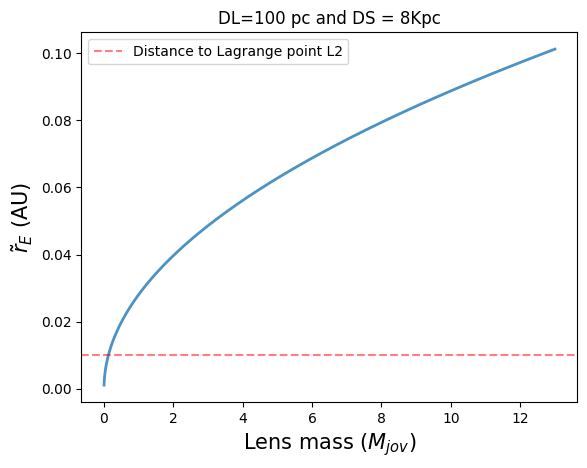

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from astropy import constants as const
from astropy import units as u
import math
from astropy.constants import c, L_sun, sigma_sb, M_jup, M_earth

# ml = np.random.uniform(1 * u.M_earth.to('M_sun'), 13 * u.M_jup.to('M_sun'))
ml = np.linspace(0.5 * u.M_earth.to('M_jup'), 13 * u.M_jup.to('M_jup'),1000)
ml = ml*u.M_jup
print(ml[-1].to('M_jup'),ml[-1].to('M_earth'))
DS = (8000 * u.pc).to('kpc')
DL = (100 * u.pc).to('kpc')
c = const.c
G = const.G
yr2day = 365.25
pi_rel = ((1 / DL) - (1 / DS))
# print(pi_rel)
k = 4 * G / (c ** 2)
aconv = (180 * 60 * 60 * 1000) / math.pi
theta_E = ((np.sqrt(k * pi_rel * ml))*u.rad.to('uas')).decompose().value
mu_rel = 10

rE_tilde = np.sqrt(k*ml/pi_rel).decompose()
# print(rE_tilde)
plt.plot(ml,rE_tilde.to('AU'),lw=2,alpha=0.8)
plt.ylabel('$\\tilde{r}_E$ (AU)',fontsize=15)
plt.xlabel('Lens mass $(M_{jov})$',fontsize=15)
print(rE_tilde[0])
plt.axhline(0.01,color='red',alpha=0.5,ls='--',label='Distance to Lagrange point L2')
# print(piE)
plt.legend()
plt.title("DL=100 pc and DS = 8Kpc")
# print(rE_tilde.to('AU'))
# # print(0.01*u.AU)

In [ ]:
# print(sum(npts))

# fit_rr[fit_rr['Source']==5118]

In [ ]:
# widths = true["t0_width"][true["Source"]==source].values[0]
# plt.hlines(*widths[1:], color="C2")

In [ ]:
# 5003.0 [2462913.981138714, 0.2900379384669427, 171.19772582817046, 0.0002104531170839, 1.823351048494769, 0.9712996669399792, 0.7549176324403909, -0.0297859820923082, 0.0320518062770783, 20, 0, 20, 0]

In [ ]:
# import pandas as pd

# # Assuming `met_1_rr` and `true` DataFrames are already defined

# # Step 1: Create a boolean mask for `true` DataFrame where `multi_peaks` is 1
# mask = true["multi_peaks"] == 1

# # Step 2: Extract the `Source` values from `true` DataFrame where `multi_peaks` is 1
# sources_with_multi_peaks = true[mask]["Source"]

# # Step 3: Filter `met_1_rr` DataFrame using these `Source` values
# filtered_met_1_rr = met_1_rr[met_1_rr["Source"].isin(sources_with_multi_peaks)]

# # Display the filtered DataFrame
# plt.hist(filtered_met_1_rr["te"])


In [ ]:
# plt.hist2d(true["u0"][true["multi_peaks"]==1],true["q"][true["multi_peaks"]==1])